# Special Teams EDA & Hypothesis Testing

What makes a prospect a pick? I've collected all this data but what will really matter when predicting a round a prospect will be picked in. I know I want to model based for each of the following position groups:

        * Quarterbacks (QBs)
        * Receivers & Running Backs (Receivers)
        * Offensive Line (OffensiveLine)
        * Linebackers (LBs)
        * Defensive Backs (DefensiveBacks)
        * Special Teams (SpecialTeams)
        
Before I start modeling, I want to check out my data and get to know what will matter when trying to nail down just which round a prospect will be selected in. I start by visualizing the distribution of my outcome in a given position group. From there I pass each variable I think I may want in my model.

In this notebook, I look into my Special Teams data.

First things first, I need to load in my models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import scipy.stats as stats
import scipy

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# setting format for readability
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.read_pickle('cleaned_df')

In [4]:
df.head()

,PlayerName,Position,School,CombineYear,Height,Weight,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle,Draft Team,Round,Pick,Draft Year,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Solo_TacklesperGame,Assisted_TacklesperGame,Ttl_TacklesperGame,LossperGame,SacksperGame,Defensive_InterceptionsperGame,Def_Int_YdsperGame,Pick_6perGame,Defended_PassesperGame,Recovered_FumblesperGame,Rec_Fumbles_YdsperGame,Fumbles_Returned_TDperGame,Forced_FumblesperGame,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,TD_OtherperGame,Ttl_TDsperGame,TwoPT_ConversionperGame,SafetyperGame,TTL_PointsperGame,Feet,Inches,Pos
0,Shaun Alexander,RB,Alabama,2000,72,218,4.58,0.00,0.00,0.00,0.00,0.00,Seattle Seahawks,1st,19th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,11.00,302.00,1383.00,4.60,19.00,25.00,323.00,12.90,4.00,327.00,1706.00,5.20,23.00,27.45,125.73,1.73,2.27,29.36,0.36,29.73,155.09,2.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,24.00,0.00,0.00,144.00,0.00,2.18,0.00,0.00,13.09,72,0,Receivers
1,LaVar Arrington,OLB,Penn State,2000,75,250,4.53,0.00,0.00,0.00,0.00,0.00,Washington Redskins,1st,2nd pick,2000,12.00,0.00,0.00,0.00,0.00,0.00,1.00,27.00,27.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,2.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,3,LBs
2,John Baker,P,North Texas,2000,75,227,0.00,0.00,0.00,0.00,0.00,0.00,0,Not Drafted,Not Drafted,Not Drafted,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,1.00,1.00,100.00,27.00,27.00,27.00,0.00,0.00,326.80,0.09,0.09,2.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,3,SpecialTeams
3,Anthony Becht,TE,West Virginia,2000,78,270,4.78,33.50,0.00,123.00,6.94,4.08,New York Jets,1st,27th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

## Functions

This is a lot of repetition so I build function to streamline the process over the 6 groups I need to investigate.

In [5]:
def position_family_df(position_family, df):
    """
    This funciton will filter for the specific position group - or family - I'm interested in for a 
    particular notebook. 
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        
    Returns:
        dataframe: filtered dataframe
        
    """
    dataframe = df[df['Pos'] == position_family]
    return dataframe

In [6]:
def plot_outcomes(position_family, df):
    """
    This function returns the count for each round a given position group has and graphs it. Along with the count,
    it will also print the normalized count -- % to total -- as a point of comparison.
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
    
    Returns:
        Dataframe shape, value counts for each round and the countplot for the distribution
        
    """
    dataframe = df
    print(position_family + ' Count: ')
    print('-'*40)
    print(position_family + ' Shape: ', dataframe.shape)
    print(dataframe['Round'].value_counts())
    print(round(dataframe['Round'].value_counts(normalize=True), 2))
    order = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
    plt.figure(figsize=(10, 6))
    sns.countplot(dataframe['Round'],order=order, palette='bright');
    plt.title(position_family + ' Round Distribution')
    plt.savefig(position_family + '_round_distro')
    plt.show()

In [7]:
def plot_stats(position_family, df, lst):
    """
    The function returns the descriptive statistics for each item in a list. The list in question is a set of 
    feature I'm parsing through to determine if they're statistically significant. I want to first check their 
    distribution by plotting each feature's boxplot.
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        lst: feature list
        
    Returns:
        Prints descriptive statistics, mean by Round for the feature and plots the distribution boxplot.
    
    """
    for i in lst:
        dataframe = df
        order = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
        print(position_family + ' ' + i + ' Summary:')
        print(dataframe[i].describe())
        print('-' * 40)
        print(position_family + ' ' + i + ' by Round')
        print(dataframe[['Round', i]].groupby(['Round']).mean())
        plt.figure(figsize = (10,6))
        plt.title(position_family + ' ' + i + ' Distribution')
        sns.boxplot(y=dataframe[i], x=dataframe['Round'], order=order)
        plt.savefig(position_family + '_' + i + '_Distro')
        plt.show()

In [8]:
def anova_tukey(position_family, df, feature):
    """
    This function runs the ANOVA test checking for significance between a given feature and the output variable along
    with the 
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        feature: feature being tested  
        
    Returns:
        Prints ANOVA test summary and Tukey-MC analysis
    
    """
    dataframe = df
    anova_rounds = ols(feature + '~Round', data=dataframe).fit()
    anova_rounds
    anova_table = sm.stats.anova_lm(anova_rounds, type=2)
    print(anova_table)
    print('')
    mc = MultiComparison(dataframe[feature], dataframe['Round'])
    mc_results = mc.tukeyhsd()
    print(mc_results.summary())

## EDA & Hypothesis Testing

In [9]:
df = position_family_df('SpecialTeams', df)
df.head()

,PlayerName,Position,School,CombineYear,Height,Weight,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle,Draft Team,Round,Pick,Draft Year,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Solo_TacklesperGame,Assisted_TacklesperGame,Ttl_TacklesperGame,LossperGame,SacksperGame,Defensive_InterceptionsperGame,Def_Int_YdsperGame,Pick_6perGame,Defended_PassesperGame,Recovered_FumblesperGame,Rec_Fumbles_YdsperGame,Fumbles_Returned_TDperGame,Forced_FumblesperGame,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,TD_OtherperGame,Ttl_TDsperGame,TwoPT_ConversionperGame,SafetyperGame,TTL_PointsperGame,Feet,Inches,Pos
2,John Baker,P,North Texas,2000,75,227,0.00,0.00,0.00,0.00,0.00,0.00,0,Not Drafted,Not Drafted,Not Drafted,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,1.00,1.00,100.00,27.00,27.00,27.00,0.00,0.00,326.80,0.09,0.09,2.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,3,SpecialTeams
6,Courtney Brown,DE,Penn State,2000,77,269,4.78,0.00,0.00,0.00,0.00,0.00,Cleveland Browns,1st,1st pick,2000,12.00,0.00,0.00,0.00,0.00,0.00,1.00,25.00,25.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,2.08,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,0.00,1.00,0.00,0.00,6.00,0.00,0.08,0.00,0.00,0.50,72,5,SpecialTeams
25,John Engelberger,DE,Virginia Tech,2000,76,260,4.73,34.00,24.00,115.00,6.95,4.28,San Francisco 49ers,2nd,35th pick,2000,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,4,SpecialTeams
43,Sebastian Janikowski,K,Florida State,2000,73,260,0.00,0.00,0.00,0.00,0.00,0.00,Oakland Raiders,1st,17th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

Special Teams Count: 
----------------------------------------
Special Teams Shape:  (1004, 121)
Not Drafted    334
1st            125
3rd            105
4th             91
2nd             90
5th             88
6th             86
7th             85
Name: Round, dtype: int64
Not Drafted   0.33
1st           0.12
3rd           0.10
4th           0.09
2nd           0.09
5th           0.09
6th           0.09
7th           0.08
Name: Round, dtype: float64


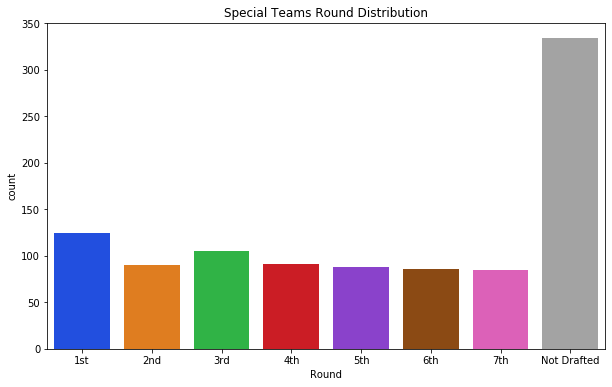

In [10]:
plot_outcomes('Special Teams', df)

### Height & Weight

In [11]:
height_weight = ['Height', 'Weight']

Special Teams Height Summary:
count   1004.00
mean      74.86
std        1.90
min       66.00
25%       74.00
50%       75.00
75%       76.00
max       80.00
Name: Height, dtype: float64
----------------------------------------
Special Teams Height by Round
             Height
Round              
1st           75.55
2nd           75.64
3rd           75.17
4th           75.25
5th           74.67
6th           74.56
7th           75.18
Not Drafted   74.24


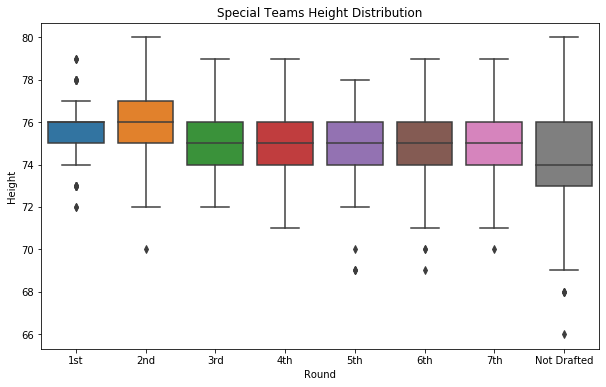

Special Teams Weight Summary:
count   1004.00
mean     270.22
std       38.65
min      164.00
25%      252.00
50%      274.00
75%      300.00
max      369.00
Name: Weight, dtype: float64
----------------------------------------
Special Teams Weight by Round
             Weight
Round              
1st          287.21
2nd          284.34
3rd          285.76
4th          281.60
5th          271.06
6th          270.17
7th          270.66
Not Drafted  251.76


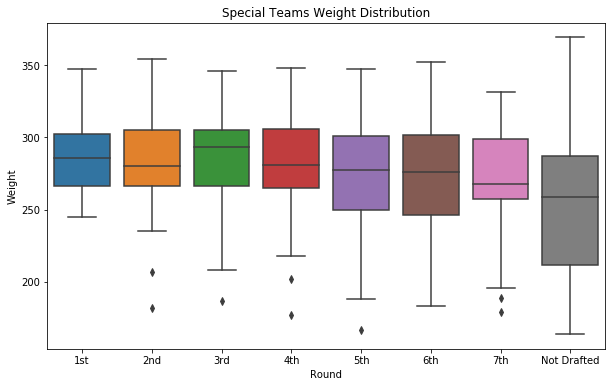

In [12]:
plot_stats('Special Teams', df, height_weight)

In [13]:
anova_tukey('Special Teams', df, 'Height')

             df  sum_sq  mean_sq     F  PR(>F)
Round      7.00  287.55    41.08 12.21    0.00
Residual 996.00 3351.48     3.36   nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd   0.0924    0.9 -0.6778  0.8627  False
   1st         3rd  -0.3806 0.7423 -1.1181   0.357  False
   1st         4th  -0.2993    0.9  -1.067  0.4685  False
   1st         5th  -0.8815 0.0134 -1.6569 -0.1062   True
   1st         6th  -0.9939 0.0029 -1.7744 -0.2133   True
   1st         7th  -0.3755 0.8085 -1.1588  0.4078  False
   1st Not Drafted  -1.3125  0.001 -1.8967 -0.7283   True
   2nd         3rd   -0.473 0.6064 -1.2734  0.3273  False
   2nd         4th  -0.3917 0.8204   -1.22  0.4366  False
   2nd         5th   -0.974 0.0098 -1.8093 -0.1387   True
   2nd         6th  -1.0863 0.0023 -1.9265 -0.2461   True
   2nd         7th   -0.468  0.671 -1.3107  0.

In [14]:
anova_tukey('Special Teams', df, 'Weight')

             df     sum_sq  mean_sq     F  PR(>F)
Round      7.00  205112.74 29301.82 22.57    0.00
Residual 996.00 1293177.28  1298.37   nan     nan

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj   lower    upper   reject
-----------------------------------------------------------
   1st         2nd  -2.8636    0.9 -17.9934  12.2663  False
   1st         3rd  -1.4461    0.9  -15.934  13.0418  False
   1st         4th  -5.6036    0.9 -20.6851   9.4779  False
   1st         5th -16.1512 0.0287 -31.3807  -0.9217   True
   1st         6th -17.0336 0.0175 -32.3667  -1.7005   True
   1st         7th -16.5492 0.0248 -31.9356  -1.1628   True
   1st Not Drafted -35.4505  0.001  -46.926  -23.975   True
   2nd         3rd   1.4175    0.9  -14.304   17.139  False
   2nd         4th    -2.74    0.9 -19.0101    13.53  False
   2nd         5th -13.2876 0.2142  -29.695   3.1198  False
   2nd         6th   -14.17 0.1542 -30.6736   2.3336  False
   2nd   

### Combine Stats

In [15]:
combine_columns = df[['_40yd', 'Vertical', 'Bench', 'BroadJump', '_3Cone', 'Shuttle']]
combine_columns.describe()

,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle
count,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00
mean,4.61,19.53,16.14,67.71,3.97,2.44
std,1.27,15.33,13.00,54.22,3.74,2.26
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.77,0.00,0.00,0.00,0.00,0.00
50%,4.92,28.00,21.00,104.00,7.01,4.23
75%,5.06,32.00,26.00,112.00,7.48,4.53
max,5.71,42.00,49.00,138.00,8.29,5.27


In [16]:
combine_stats = ['_40yd', 'Vertical', 'Bench', 'BroadJump', '_3Cone', 'Shuttle']

Special Teams _40yd Summary:
count   1004.00
mean       4.61
std        1.27
min        0.00
25%        4.77
50%        4.92
75%        5.06
max        5.71
Name: _40yd, dtype: float64
----------------------------------------
Special Teams _40yd by Round
             _40yd
Round             
1st           4.67
2nd           4.81
3rd           4.79
4th           4.83
5th           4.30
6th           4.78
7th           4.48
Not Drafted   4.48


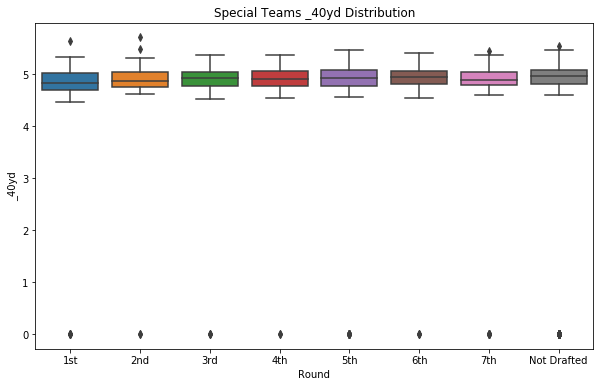

Special Teams Vertical Summary:
count   1004.00
mean      19.53
std       15.33
min        0.00
25%        0.00
50%       28.00
75%       32.00
max       42.00
Name: Vertical, dtype: float64
----------------------------------------
Special Teams Vertical by Round
             Vertical
Round                
1st             25.28
2nd             23.70
3rd             24.85
4th             22.91
5th             15.86
6th             20.55
7th             21.86
Not Drafted     13.76


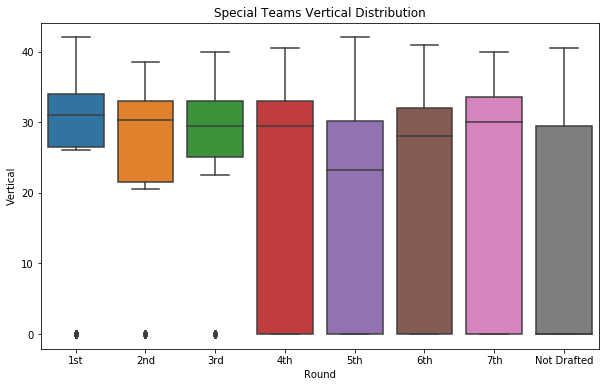

Special Teams Bench Summary:
count   1004.00
mean      16.14
std       13.00
min        0.00
25%        0.00
50%       21.00
75%       26.00
max       49.00
Name: Bench, dtype: float64
----------------------------------------
Special Teams Bench by Round
             Bench
Round             
1st          20.02
2nd          19.62
3rd          19.06
4th          18.73
5th          16.60
6th          15.62
7th          18.45
Not Drafted  11.55


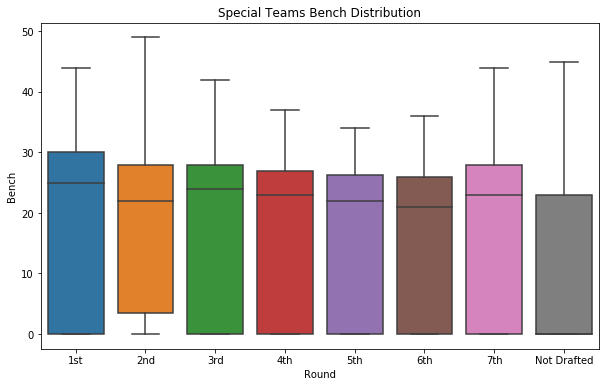

Special Teams BroadJump Summary:
count   1004.00
mean      67.71
std       54.22
min        0.00
25%        0.00
50%      104.00
75%      112.00
max      138.00
Name: BroadJump, dtype: float64
----------------------------------------
Special Teams BroadJump by Round
             BroadJump
Round                 
1st              84.70
2nd              81.39
3rd              86.77
4th              78.74
5th              54.66
6th              74.34
7th              70.86
Not Drafted      49.59


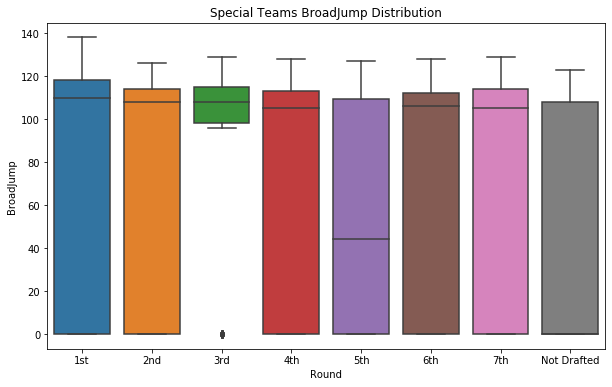

Special Teams _3Cone Summary:
count   1004.00
mean       3.97
std        3.74
min        0.00
25%        0.00
50%        7.01
75%        7.48
max        8.29
Name: _3Cone, dtype: float64
----------------------------------------
Special Teams _3Cone by Round
             _3Cone
Round              
1st            4.77
2nd            4.79
3rd            5.57
4th            4.37
5th            3.23
6th            4.38
7th            4.27
Not Drafted    2.84


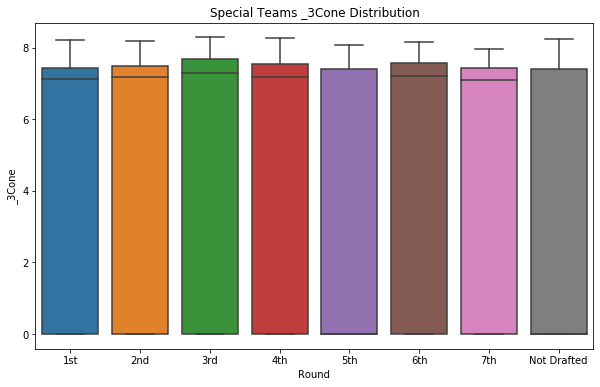

Special Teams Shuttle Summary:
count   1004.00
mean       2.44
std        2.26
min        0.00
25%        0.00
50%        4.23
75%        4.53
max        5.27
Name: Shuttle, dtype: float64
----------------------------------------
Special Teams Shuttle by Round
             Shuttle
Round               
1st             2.97
2nd             2.95
3rd             3.24
4th             2.62
5th             1.99
6th             2.62
7th             2.75
Not Drafted     1.79


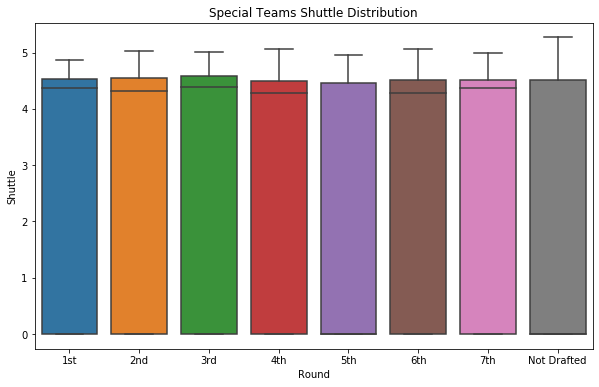

In [17]:
plot_stats('Special Teams', df, combine_stats)

In [18]:
for i in combine_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Special Teams', df, i)
    print('')
    print('*' * 60)

_40yd ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   29.10     4.16 2.62    0.01
Residual 996.00 1579.94     1.59  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.1349    0.9  -0.394 0.6637  False
   1st         3rd   0.1166    0.9 -0.3898  0.623  False
   1st         4th   0.1544    0.9 -0.3728 0.6815  False
   1st         5th  -0.3692 0.4139 -0.9015 0.1632  False
   1st         6th   0.1119    0.9  -0.424 0.6479  False
   1st         7th  -0.1892    0.9  -0.727 0.3486  False
   1st Not Drafted  -0.1872 0.8314 -0.5884 0.2139  False
   2nd         3rd  -0.0183    0.9 -0.5679 0.5312  False
   2nd         4th   0.0195    0.9 -0.5492 0.5882  False
   2nd         5th  -0.5041 0.1328 -1.0776 0.0694  False
   2nd         6th   -0.023    0.9 -0.5998 0.5539  False
   2

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd   0.0149    0.9 -1.5083  1.5382  False
   1st         3rd   0.7994 0.6842 -0.6592   2.258  False
   1st         4th  -0.4056    0.9 -1.9239  1.1128  False
   1st         5th  -1.5387 0.0485 -3.0719 -0.0054   True
   1st         6th  -0.3937    0.9 -1.9374    1.15  False
   1st         7th  -0.5003    0.9 -2.0493  1.0488  False
   1st Not Drafted  -1.9279  0.001 -3.0833 -0.7726   True
   2nd         3rd   0.7845 0.7792 -0.7983  2.3673  False
   2nd         4th  -0.4205    0.9 -2.0586  1.2175  False
   2nd         5th  -1.5536 0.0831 -3.2054  0.0983  False
   2nd         6th  -0.4086    0.9 -2.0702  1.2529  False
   2nd         7th  -0.5152    0.9 -2.1817  1.1513  False
   2nd Not Drafted  -1.9429  0.001 -3.2515 -0.6343   True
   3rd         4th   -1.205 0.2841 -2.7831  0.3731  False
   3rd        

### College Stats - Passing

In [19]:
passing_stats = ['Passing_Games', 'Completions', 'Pass_Attempts', 'Completion_Percent', 'Pass_Yards', 
                 'Pass_Yds_per_Attempt', 'Adj_Pass_Yds_per_Attempt', 'Pass_TDs', 'Pass_Interceptions', 'Passer_Rating', 
                 'CompletionsperGame', 'Pass_AttemptsperGame', 'Pass_YardsperGame', 'Pass_TDsperGame', 
                 'Pass_InterceptionsperGame']

In [20]:
df[passing_stats].describe()

,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame
count,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00
mean,0.64,0.02,0.03,1.89,0.27,0.24,0.22,0.00,0.00,4.19,0.00,0.00,0.02,0.00,0.00
std,2.71,0.15,0.19,13.45,2.91,2.72,3.27,0.04,0.03,38.02,0.01,0.02,0.25,0.00,0.00
min,0.00,0.00,0.00,0.00,-9.00,-9.00,-45.00,0.00,0.00,-200.00,0.00,0.00,-0.64,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,14.00,2.00,2.00,100.00,64.00,64.00,64.00,1.00,1.00,637.60,0.18,0.18,5.33,0.09,0.08


Special Teams Passing_Games Summary:
count   1004.00
mean       0.64
std        2.71
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       14.00
Name: Passing_Games, dtype: float64
----------------------------------------
Special Teams Passing_Games by Round
             Passing_Games
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.25
4th                   0.37
5th                   0.57
6th                   0.29
7th                   0.41
Not Drafted           1.41


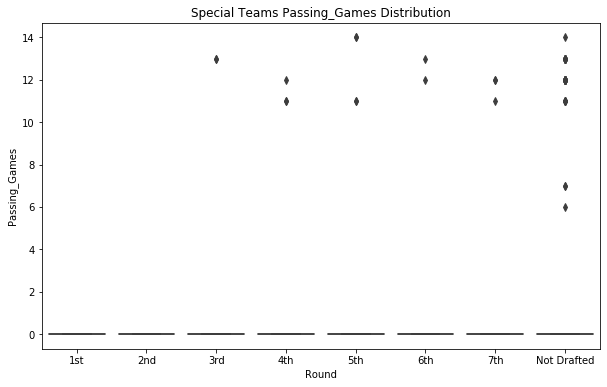

Special Teams Completions Summary:
count   1004.00
mean       0.02
std        0.15
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.00
Name: Completions, dtype: float64
----------------------------------------
Special Teams Completions by Round
             Completions
Round                   
1st                 0.00
2nd                 0.00
3rd                 0.01
4th                 0.01
5th                 0.01
6th                 0.01
7th                 0.01
Not Drafted         0.05


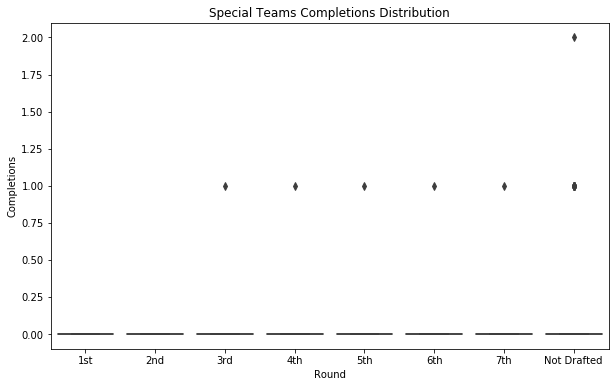

Special Teams Pass_Attempts Summary:
count   1004.00
mean       0.03
std        0.19
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.00
Name: Pass_Attempts, dtype: float64
----------------------------------------
Special Teams Pass_Attempts by Round
             Pass_Attempts
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.01
4th                   0.01
5th                   0.02
6th                   0.01
7th                   0.02
Not Drafted           0.07


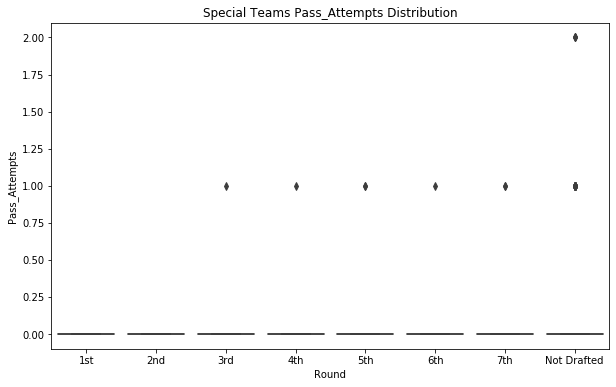

Special Teams Completion_Percent Summary:
count   1004.00
mean       1.89
std       13.45
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      100.00
Name: Completion_Percent, dtype: float64
----------------------------------------
Special Teams Completion_Percent by Round
             Completion_Percent
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.95
4th                        1.10
5th                        1.14
6th                        1.16
7th                        1.18
Not Drafted                4.19


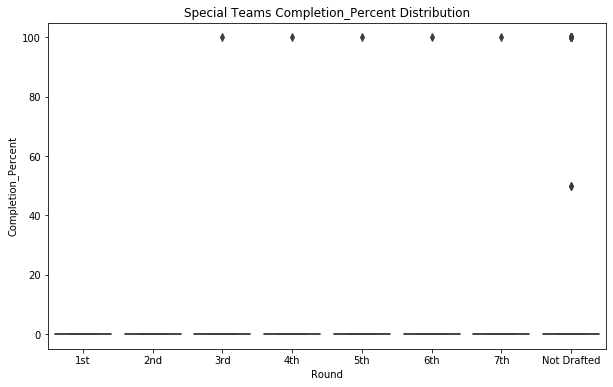

Special Teams Pass_Yards Summary:
count   1004.00
mean       0.27
std        2.91
min       -9.00
25%        0.00
50%        0.00
75%        0.00
max       64.00
Name: Pass_Yards, dtype: float64
----------------------------------------
Special Teams Pass_Yards by Round
             Pass_Yards
Round                  
1st                0.00
2nd                0.00
3rd                0.18
4th                0.07
5th               -0.10
6th                0.08
7th               -0.01
Not Drafted        0.74


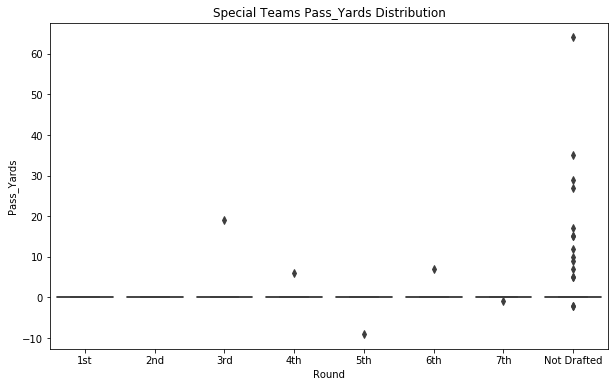

Special Teams Pass_Yds_per_Attempt Summary:
count   1004.00
mean       0.24
std        2.72
min       -9.00
25%        0.00
50%        0.00
75%        0.00
max       64.00
Name: Pass_Yds_per_Attempt, dtype: float64
----------------------------------------
Special Teams Pass_Yds_per_Attempt by Round
             Pass_Yds_per_Attempt
Round                            
1st                          0.00
2nd                          0.00
3rd                          0.18
4th                          0.07
5th                         -0.10
6th                          0.08
7th                         -0.01
Not Drafted                  0.65


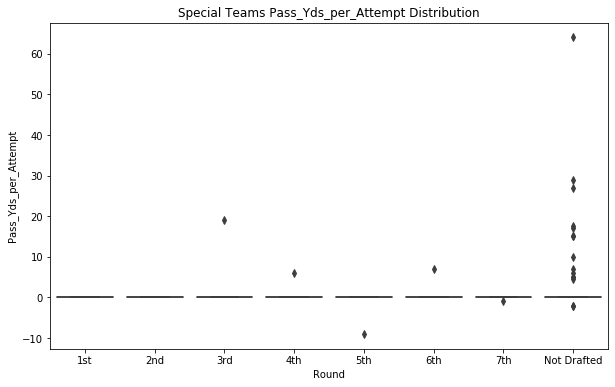

Special Teams Adj_Pass_Yds_per_Attempt Summary:
count   1004.00
mean       0.22
std        3.27
min      -45.00
25%        0.00
50%        0.00
75%        0.00
max       64.00
Name: Adj_Pass_Yds_per_Attempt, dtype: float64
----------------------------------------
Special Teams Adj_Pass_Yds_per_Attempt by Round
             Adj_Pass_Yds_per_Attempt
Round                                
1st                              0.00
2nd                              0.00
3rd                              0.18
4th                              0.07
5th                             -0.10
6th                              0.08
7th                             -0.01
Not Drafted                      0.61


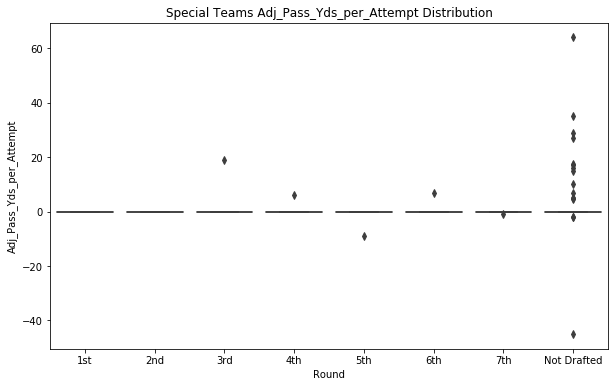

Special Teams Pass_TDs Summary:
count   1004.00
mean       0.00
std        0.04
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Pass_TDs, dtype: float64
----------------------------------------
Special Teams Pass_TDs by Round
             Pass_TDs
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.01


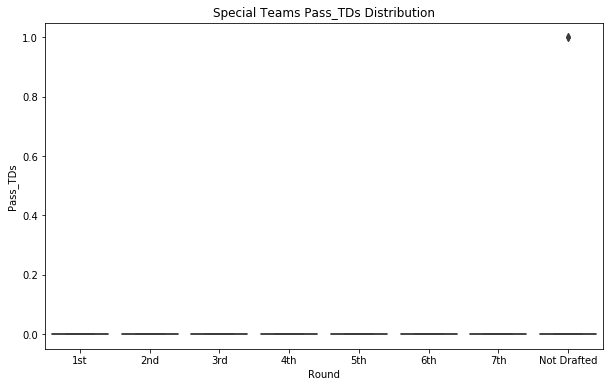

Special Teams Pass_Interceptions Summary:
count   1004.00
mean       0.00
std        0.03
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Pass_Interceptions, dtype: float64
----------------------------------------
Special Teams Pass_Interceptions by Round
             Pass_Interceptions
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


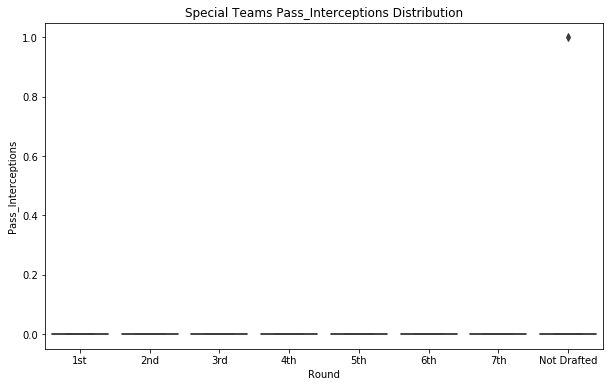

Special Teams Passer_Rating Summary:
count   1004.00
mean       4.19
std       38.02
min     -200.00
25%        0.00
50%        0.00
75%        0.00
max      637.60
Name: Passer_Rating, dtype: float64
----------------------------------------
Special Teams Passer_Rating by Round
             Passer_Rating
Round                     
1st                   0.00
2nd                   0.00
3rd                   2.47
4th                   1.65
5th                   0.28
6th                   1.85
7th                   1.08
Not Drafted          10.56


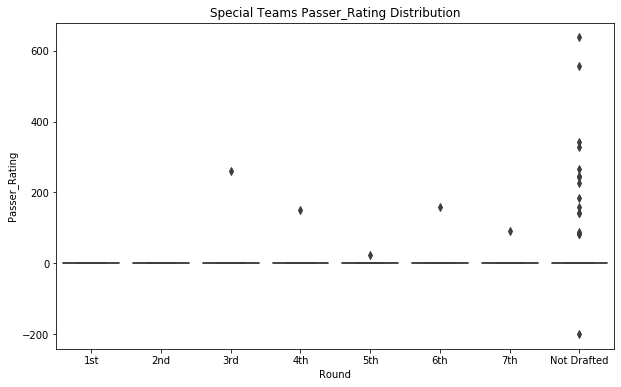

Special Teams CompletionsperGame Summary:
count   1004.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.18
Name: CompletionsperGame, dtype: float64
----------------------------------------
Special Teams CompletionsperGame by Round
             CompletionsperGame
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


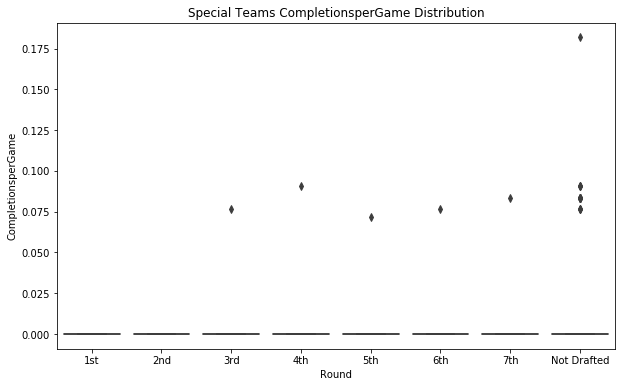

Special Teams Pass_AttemptsperGame Summary:
count   1004.00
mean       0.00
std        0.02
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.18
Name: Pass_AttemptsperGame, dtype: float64
----------------------------------------
Special Teams Pass_AttemptsperGame by Round
             Pass_AttemptsperGame
Round                            
1st                          0.00
2nd                          0.00
3rd                          0.00
4th                          0.00
5th                          0.00
6th                          0.00
7th                          0.00
Not Drafted                  0.01


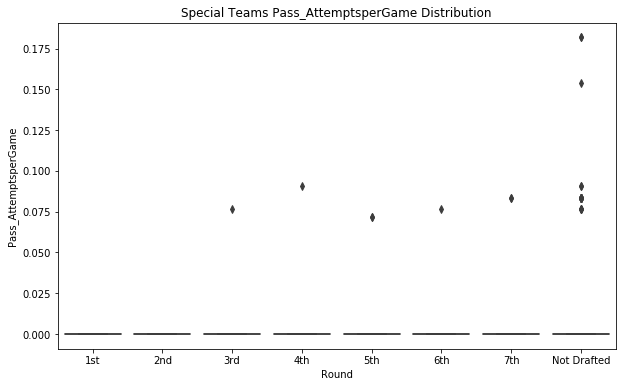

Special Teams Pass_YardsperGame Summary:
count   1004.00
mean       0.02
std        0.25
min       -0.64
25%        0.00
50%        0.00
75%        0.00
max        5.33
Name: Pass_YardsperGame, dtype: float64
----------------------------------------
Special Teams Pass_YardsperGame by Round
             Pass_YardsperGame
Round                         
1st                       0.00
2nd                       0.00
3rd                       0.01
4th                       0.01
5th                      -0.01
6th                       0.01
7th                      -0.00
Not Drafted               0.06


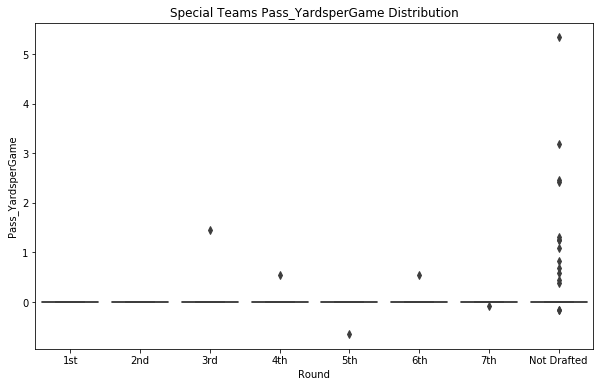

Special Teams Pass_TDsperGame Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.09
Name: Pass_TDsperGame, dtype: float64
----------------------------------------
Special Teams Pass_TDsperGame by Round
             Pass_TDsperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


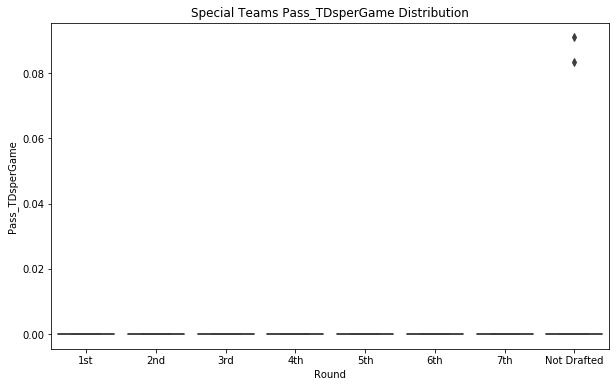

Special Teams Pass_InterceptionsperGame Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.08
Name: Pass_InterceptionsperGame, dtype: float64
----------------------------------------
Special Teams Pass_InterceptionsperGame by Round
             Pass_InterceptionsperGame
Round                                 
1st                               0.00
2nd                               0.00
3rd                               0.00
4th                               0.00
5th                               0.00
6th                               0.00
7th                               0.00
Not Drafted                       0.00


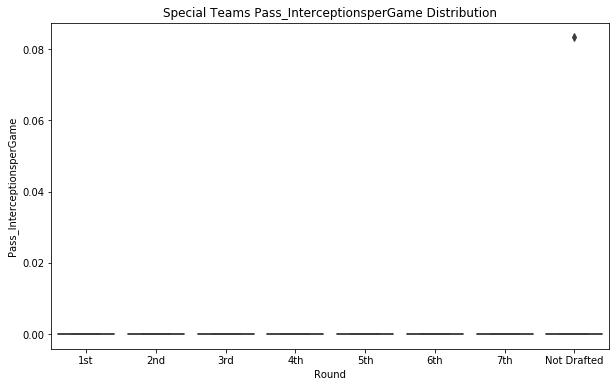

In [21]:
plot_stats('Special Teams', df, passing_stats)

In [22]:
for i in passing_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Defensive Backs', df, i)
    print('')
    print('*' * 40)

Passing_Games ANOVA Test:
----------------------------------------
              df  sum_sq  mean_sq    F  PR(>F)
Round       7.00    6.40     0.91 0.43    0.88
Residual 1093.00 2312.77     2.12  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0984    0.9 -0.6587 0.4618  False
   1st         3rd  -0.1175    0.9 -0.6809  0.446  False
   1st         4th   -0.212    0.9 -0.7766 0.3526  False
   1st         5th  -0.1947    0.9 -0.7725  0.383  False
   1st         6th  -0.0356    0.9 -0.6576 0.5864  False
   1st         7th     -0.3 0.8555 -0.9614 0.3614  False
   1st Not Drafted  -0.1116    0.9 -0.5826 0.3595  False
   2nd         3rd   -0.019    0.9 -0.5723 0.5343  False
   2nd         4th  -0.1136    0.9  -0.668 0.4409  False
   2nd         5th  -0.0963    0.9 -0.6641 0.4715  False
   2nd         6th   0.0628    0.9   -0.55 0.6756 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.0837    0.9 -0.4435 0.6109  False
   1st         3rd   0.2857 0.7011 -0.2445  0.816  False
   1st         4th      0.0    0.9 -0.5313 0.5313  False
   1st         5th      0.0    0.9 -0.5437 0.5437  False
   1st         6th      0.0    0.9 -0.5854 0.5854  False
   1st         7th      0.0    0.9 -0.6224 0.6224  False
   1st Not Drafted   0.0991    0.9 -0.3442 0.5424  False
   2nd         3rd    0.202    0.9 -0.3187 0.7227  False
   2nd         4th  -0.0837    0.9 -0.6055  0.438  False
   2nd         5th  -0.0837    0.9 -0.6181 0.4506  False
   2nd         6th  -0.0837    0.9 -0.6604  0.493  False
   2nd         7th  -0.0837    0.9  -0.698 0.5306  False
   2nd Not Drafted   0.0154    0.9 -0.4165 0.4472  False
   3rd         4th  -0.2857 0.6909 -0.8105 0.2391  False
   3rd         5th  -0.2857  0.

              df  sum_sq  mean_sq    F  PR(>F)
Round       7.00    1.07     0.15 0.33    0.94
Residual 1093.00  506.56     0.46  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1    group2   meandiff p-adj  lower  upper  reject
-------------------------------------------------------
   1st         2nd   0.0024   0.9 -0.2598 0.2646  False
   1st         3rd   0.0013   0.9 -0.2624  0.265  False
   1st         4th      0.0   0.9 -0.2642 0.2642  False
   1st         5th      0.0   0.9 -0.2704 0.2704  False
   1st         6th      0.0   0.9 -0.2911 0.2911  False
   1st         7th      0.0   0.9 -0.3095 0.3095  False
   1st Not Drafted   0.0688   0.9 -0.1517 0.2892  False
   2nd         3rd  -0.0011   0.9   -0.26 0.2579  False
   2nd         4th  -0.0024   0.9 -0.2619 0.2571  False
   2nd         5th  -0.0024   0.9 -0.2681 0.2634  False
   2nd         6th  -0.0024   0.9 -0.2892 0.2844  False
   2nd         7th  -0.0024   0.9 -0.3079 0.3031  False
   2nd Not Drafted

### College Stats - Rushing & Receiving

In [22]:
rushing_stats = ['Rush_Rec_Games', 'Rush_Attempts', 'Rush_Yds', 'Rush_Yds_per_Attempt', 'Rush_TDs', 
                 'Receptions', 'Rec_Yds', 'Rec_Yds_per_Reception', 'Rec_TDs', 'Plays_from_Scrimmage', 'Scrimmage_Yds',
                 'Scrimmage_Yds_per_Attempt', 'Scrimmage_TDs', 'Rush_AttemptsperGame', 'Rush_YdsperGame', 
                 'Rush_TDsperGame', 'ReceptionsperGame', 'Rec_YdsperGame', 'Rec_TDsperGame', 
                 'Plays_from_ScrimmageperGame', 'Scrimmage_YdsperGame', 'Scrimmage_TDsperGame']

In [23]:
df[rushing_stats].describe()

,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame
count,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00
mean,1.45,0.15,0.80,0.35,0.01,0.00,0.05,0.05,0.00,0.15,0.85,0.36,0.01,0.01,0.08,0.00,0.00,0.01,0.00,0.01,0.08,0.00
std,3.99,1.51,8.10,3.16,0.15,0.04,1.13,1.13,0.03,1.54,8.61,3.17,0.16,0.18,0.91,0.01,0.01,0.12,0.00,0.18,0.97,0.01
min,0.00,0.00,-19.00,-16.00,0.00,0.00,0.00,0.00,0.00,0.00,-19.00,-16.00,0.00,0.00,-1.73,0.00,0.00,0.00,0.00,0.00,-1.73,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,15.00,43.00,201.00,39.00,3.00,1.00,31.00,31.00,1.00,44.00,219.00,39.00,3.00,5.38,25.12,0.27,0.12,3.10,0.10,5.50,27.38,0.30


Special Teams Rush_Rec_Games Summary:
count   1004.00
mean       1.45
std        3.99
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       15.00
Name: Rush_Rec_Games, dtype: float64
----------------------------------------
Special Teams Rush_Rec_Games by Round
             Rush_Rec_Games
Round                      
1st                    0.81
2nd                    0.42
3rd                    0.48
4th                    0.97
5th                    1.59
6th                    1.70
7th                    0.45
Not Drafted            2.56


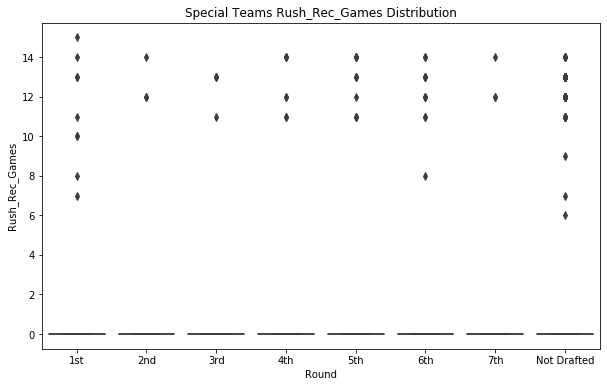

Special Teams Rush_Attempts Summary:
count   1004.00
mean       0.15
std        1.51
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       43.00
Name: Rush_Attempts, dtype: float64
----------------------------------------
Special Teams Rush_Attempts by Round
             Rush_Attempts
Round                     
1st                   0.21
2nd                   0.04
3rd                   0.03
4th                   0.09
5th                   0.06
6th                   0.55
7th                   0.06
Not Drafted           0.15


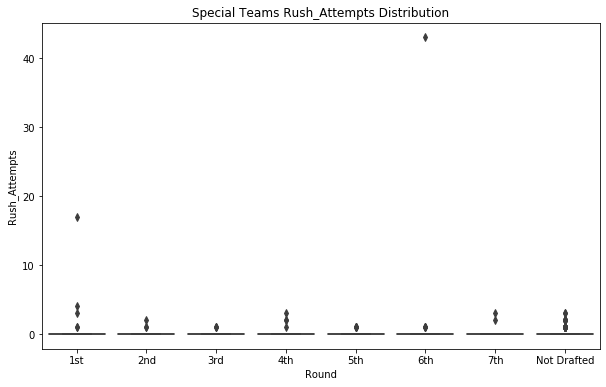

Special Teams Rush_Yds Summary:
count   1004.00
mean       0.80
std        8.10
min      -19.00
25%        0.00
50%        0.00
75%        0.00
max      201.00
Name: Rush_Yds, dtype: float64
----------------------------------------
Special Teams Rush_Yds by Round
             Rush_Yds
Round                
1st              0.77
2nd              0.07
3rd              0.00
4th              0.67
5th              0.70
6th              2.34
7th              0.54
Not Drafted      0.99


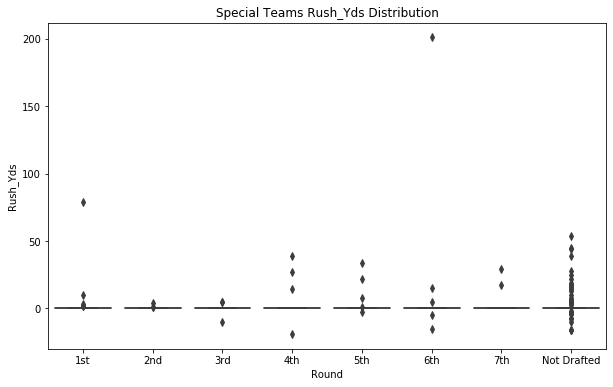

Special Teams Rush_Yds_per_Attempt Summary:
count   1004.00
mean       0.35
std        3.16
min      -16.00
25%        0.00
50%        0.00
75%        0.00
max       39.00
Name: Rush_Yds_per_Attempt, dtype: float64
----------------------------------------
Special Teams Rush_Yds_per_Attempt by Round
             Rush_Yds_per_Attempt
Round                            
1st                          0.14
2nd                          0.06
3rd                          0.00
4th                          0.46
5th                          0.70
6th                          0.05
7th                          0.21
Not Drafted                  0.60


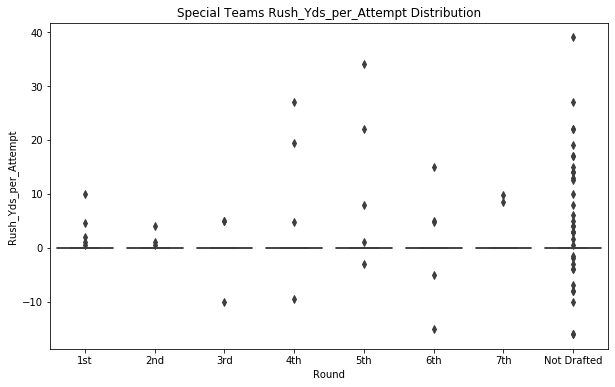

Special Teams Rush_TDs Summary:
count   1004.00
mean       0.01
std        0.15
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        3.00
Name: Rush_TDs, dtype: float64
----------------------------------------
Special Teams Rush_TDs by Round
             Rush_TDs
Round                
1st              0.06
2nd              0.02
3rd              0.01
4th              0.00
5th              0.01
6th              0.00
7th              0.00
Not Drafted      0.00


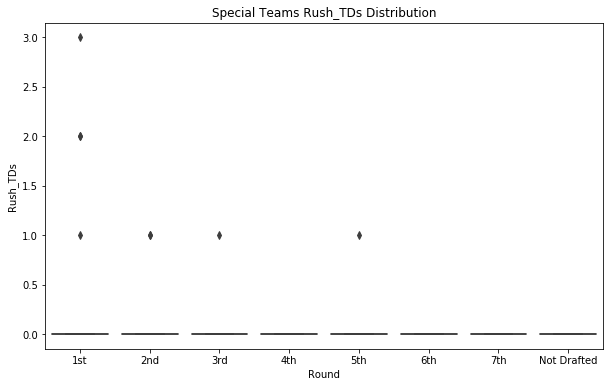

Special Teams Receptions Summary:
count   1004.00
mean       0.00
std        0.04
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Receptions, dtype: float64
----------------------------------------
Special Teams Receptions by Round
             Receptions
Round                  
1st                0.01
2nd                0.00
3rd                0.00
4th                0.00
5th                0.00
6th                0.01
7th                0.00
Not Drafted        0.00


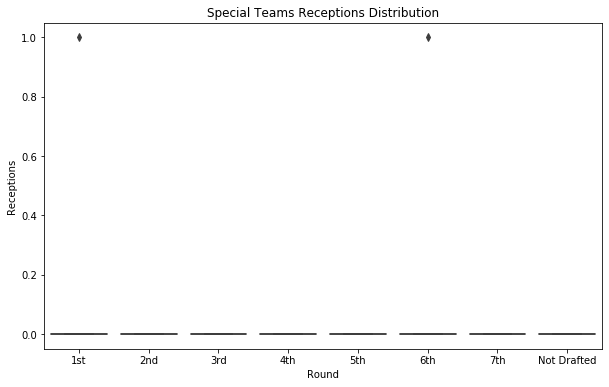

Special Teams Rec_Yds Summary:
count   1004.00
mean       0.05
std        1.13
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       31.00
Name: Rec_Yds, dtype: float64
----------------------------------------
Special Teams Rec_Yds by Round
             Rec_Yds
Round               
1st             0.25
2nd             0.00
3rd             0.00
4th             0.00
5th             0.00
6th             0.21
7th             0.00
Not Drafted     0.00


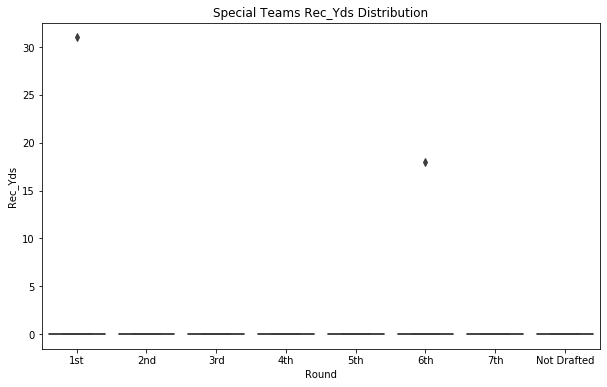

Special Teams Rec_Yds_per_Reception Summary:
count   1004.00
mean       0.05
std        1.13
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       31.00
Name: Rec_Yds_per_Reception, dtype: float64
----------------------------------------
Special Teams Rec_Yds_per_Reception by Round
             Rec_Yds_per_Reception
Round                             
1st                           0.25
2nd                           0.00
3rd                           0.00
4th                           0.00
5th                           0.00
6th                           0.21
7th                           0.00
Not Drafted                   0.00


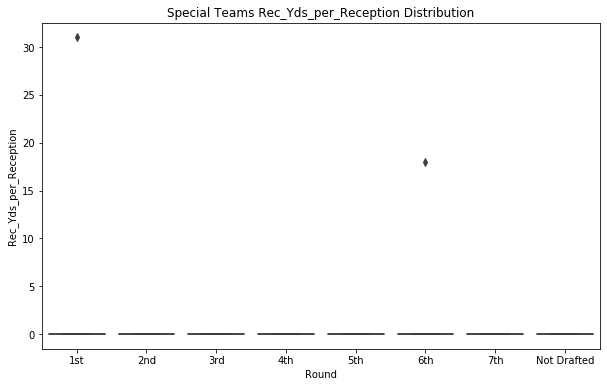

Special Teams Rec_TDs Summary:
count   1004.00
mean       0.00
std        0.03
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Rec_TDs, dtype: float64
----------------------------------------
Special Teams Rec_TDs by Round
             Rec_TDs
Round               
1st             0.01
2nd             0.00
3rd             0.00
4th             0.00
5th             0.00
6th             0.00
7th             0.00
Not Drafted     0.00


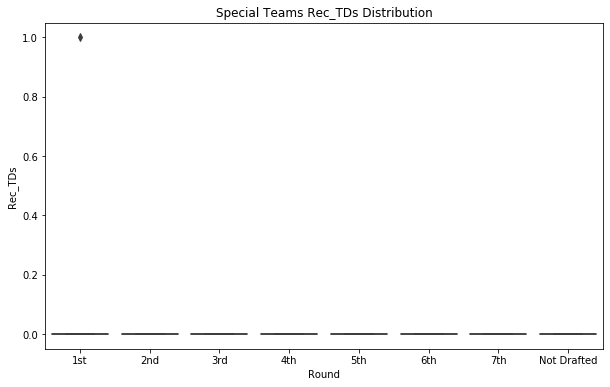

Special Teams Plays_from_Scrimmage Summary:
count   1004.00
mean       0.15
std        1.54
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       44.00
Name: Plays_from_Scrimmage, dtype: float64
----------------------------------------
Special Teams Plays_from_Scrimmage by Round
             Plays_from_Scrimmage
Round                            
1st                          0.22
2nd                          0.04
3rd                          0.03
4th                          0.09
5th                          0.06
6th                          0.56
7th                          0.06
Not Drafted                  0.15


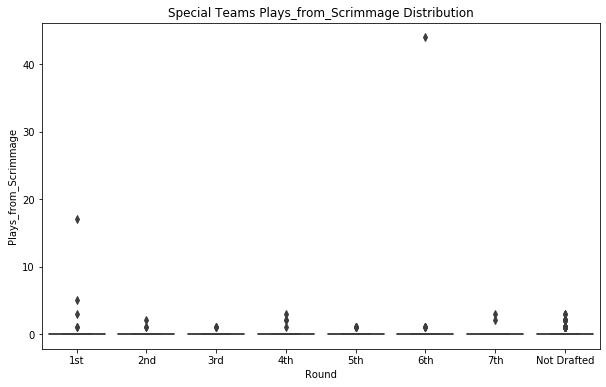

Special Teams Scrimmage_Yds Summary:
count   1004.00
mean       0.85
std        8.61
min      -19.00
25%        0.00
50%        0.00
75%        0.00
max      219.00
Name: Scrimmage_Yds, dtype: float64
----------------------------------------
Special Teams Scrimmage_Yds by Round
             Scrimmage_Yds
Round                     
1st                   1.02
2nd                   0.07
3rd                   0.00
4th                   0.67
5th                   0.70
6th                   2.55
7th                   0.54
Not Drafted           0.99


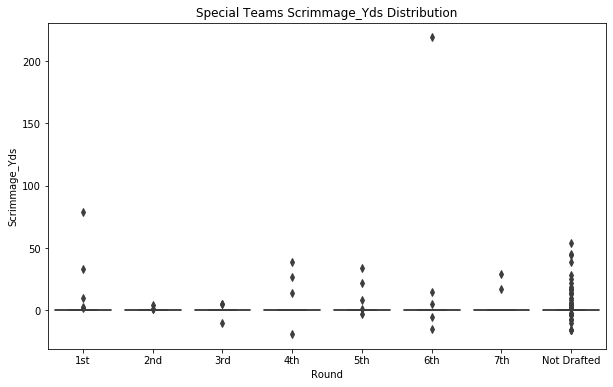

Special Teams Scrimmage_Yds_per_Attempt Summary:
count   1004.00
mean       0.36
std        3.17
min      -16.00
25%        0.00
50%        0.00
75%        0.00
max       39.00
Name: Scrimmage_Yds_per_Attempt, dtype: float64
----------------------------------------
Special Teams Scrimmage_Yds_per_Attempt by Round
             Scrimmage_Yds_per_Attempt
Round                                 
1st                               0.19
2nd                               0.06
3rd                               0.00
4th                               0.46
5th                               0.70
6th                               0.06
7th                               0.21
Not Drafted                       0.60


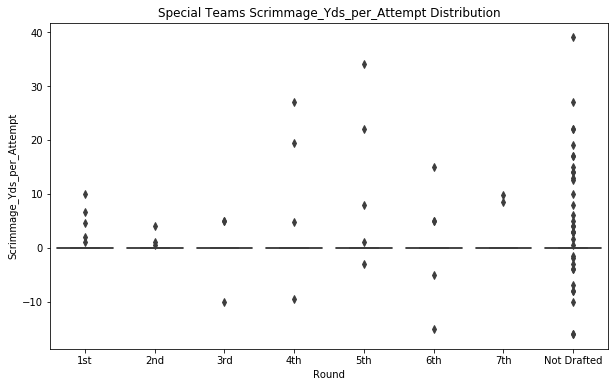

Special Teams Scrimmage_TDs Summary:
count   1004.00
mean       0.01
std        0.16
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        3.00
Name: Scrimmage_TDs, dtype: float64
----------------------------------------
Special Teams Scrimmage_TDs by Round
             Scrimmage_TDs
Round                     
1st                   0.07
2nd                   0.02
3rd                   0.01
4th                   0.00
5th                   0.01
6th                   0.00
7th                   0.00
Not Drafted           0.00


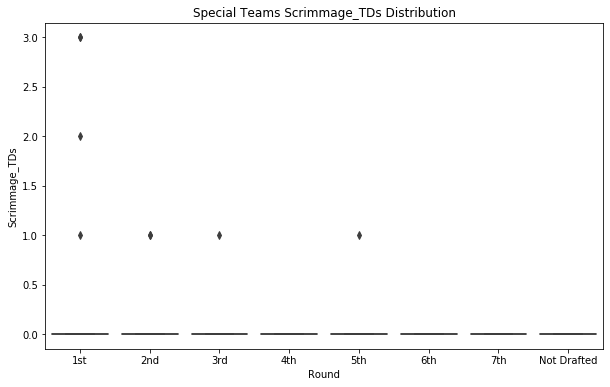

Special Teams Rush_AttemptsperGame Summary:
count   1004.00
mean       0.01
std        0.18
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        5.38
Name: Rush_AttemptsperGame, dtype: float64
----------------------------------------
Special Teams Rush_AttemptsperGame by Round
             Rush_AttemptsperGame
Round                            
1st                          0.02
2nd                          0.00
3rd                          0.00
4th                          0.01
5th                          0.00
6th                          0.07
7th                          0.00
Not Drafted                  0.01


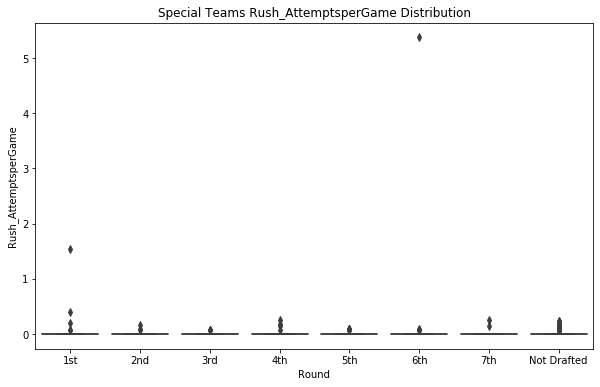

Special Teams Rush_YdsperGame Summary:
count   1004.00
mean       0.08
std        0.91
min       -1.73
25%        0.00
50%        0.00
75%        0.00
max       25.12
Name: Rush_YdsperGame, dtype: float64
----------------------------------------
Special Teams Rush_YdsperGame by Round
             Rush_YdsperGame
Round                       
1st                     0.07
2nd                     0.01
3rd                     0.00
4th                     0.05
5th                     0.06
6th                     0.29
7th                     0.04
Not Drafted             0.09


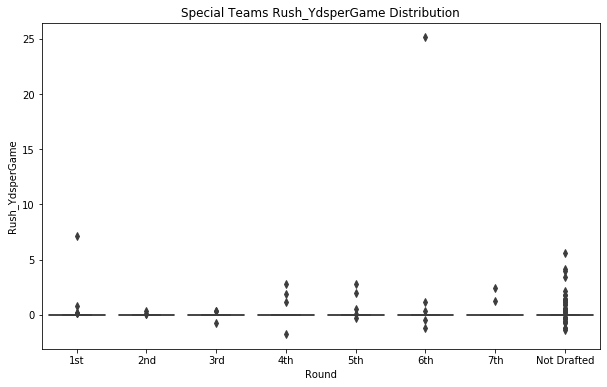

Special Teams Rush_TDsperGame Summary:
count   1004.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.27
Name: Rush_TDsperGame, dtype: float64
----------------------------------------
Special Teams Rush_TDsperGame by Round
             Rush_TDsperGame
Round                       
1st                     0.01
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


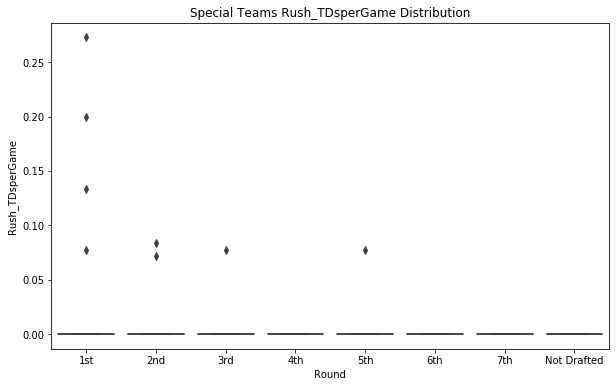

Special Teams ReceptionsperGame Summary:
count   1004.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.12
Name: ReceptionsperGame, dtype: float64
----------------------------------------
Special Teams ReceptionsperGame by Round
             ReceptionsperGame
Round                         
1st                       0.00
2nd                       0.00
3rd                       0.00
4th                       0.00
5th                       0.00
6th                       0.00
7th                       0.00
Not Drafted               0.00


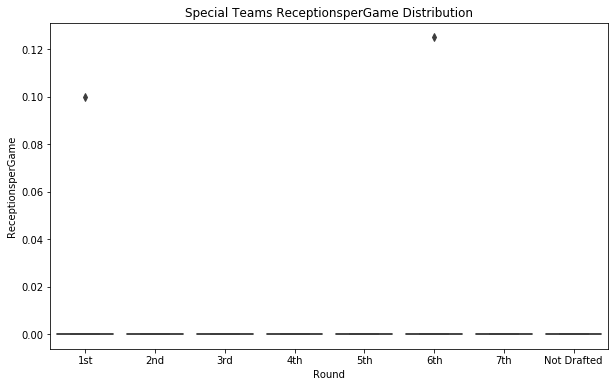

Special Teams Rec_YdsperGame Summary:
count   1004.00
mean       0.01
std        0.12
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        3.10
Name: Rec_YdsperGame, dtype: float64
----------------------------------------
Special Teams Rec_YdsperGame by Round
             Rec_YdsperGame
Round                      
1st                    0.02
2nd                    0.00
3rd                    0.00
4th                    0.00
5th                    0.00
6th                    0.03
7th                    0.00
Not Drafted            0.00


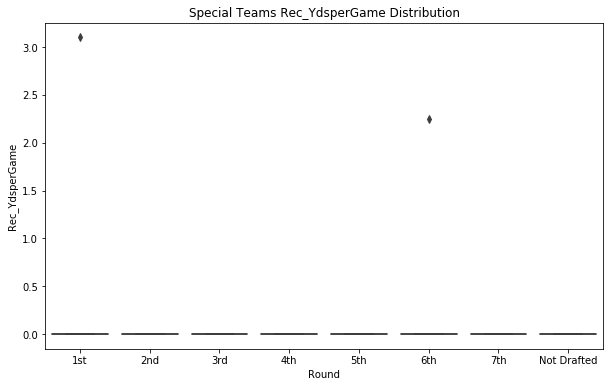

Special Teams Rec_TDsperGame Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.10
Name: Rec_TDsperGame, dtype: float64
----------------------------------------
Special Teams Rec_TDsperGame by Round
             Rec_TDsperGame
Round                      
1st                    0.00
2nd                    0.00
3rd                    0.00
4th                    0.00
5th                    0.00
6th                    0.00
7th                    0.00
Not Drafted            0.00


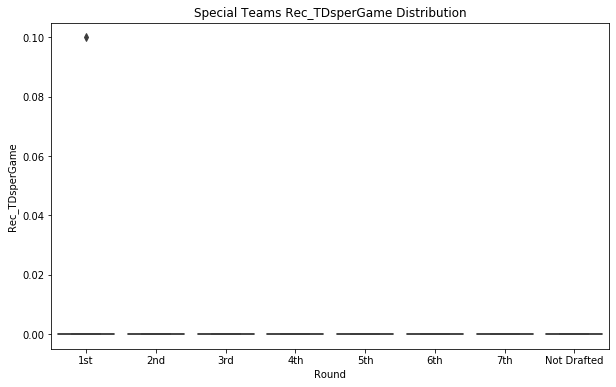

Special Teams Plays_from_ScrimmageperGame Summary:
count   1004.00
mean       0.01
std        0.18
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        5.50
Name: Plays_from_ScrimmageperGame, dtype: float64
----------------------------------------
Special Teams Plays_from_ScrimmageperGame by Round
             Plays_from_ScrimmageperGame
Round                                   
1st                                 0.02
2nd                                 0.00
3rd                                 0.00
4th                                 0.01
5th                                 0.00
6th                                 0.07
7th                                 0.00
Not Drafted                         0.01


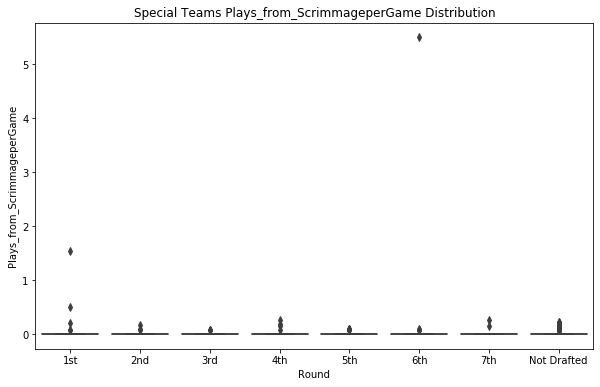

Special Teams Scrimmage_YdsperGame Summary:
count   1004.00
mean       0.08
std        0.97
min       -1.73
25%        0.00
50%        0.00
75%        0.00
max       27.38
Name: Scrimmage_YdsperGame, dtype: float64
----------------------------------------
Special Teams Scrimmage_YdsperGame by Round
             Scrimmage_YdsperGame
Round                            
1st                          0.09
2nd                          0.01
3rd                          0.00
4th                          0.05
5th                          0.06
6th                          0.32
7th                          0.04
Not Drafted                  0.09


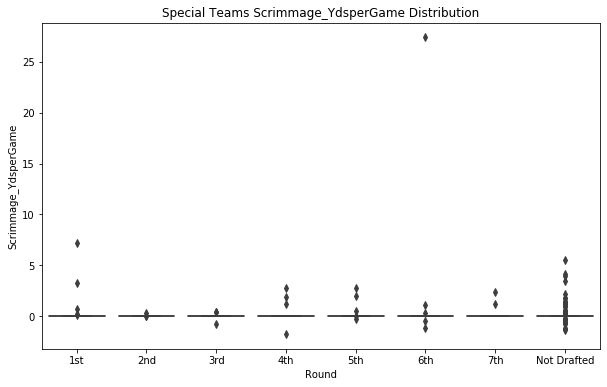

Special Teams Scrimmage_TDsperGame Summary:
count   1004.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.30
Name: Scrimmage_TDsperGame, dtype: float64
----------------------------------------
Special Teams Scrimmage_TDsperGame by Round
             Scrimmage_TDsperGame
Round                            
1st                          0.01
2nd                          0.00
3rd                          0.00
4th                          0.00
5th                          0.00
6th                          0.00
7th                          0.00
Not Drafted                  0.00


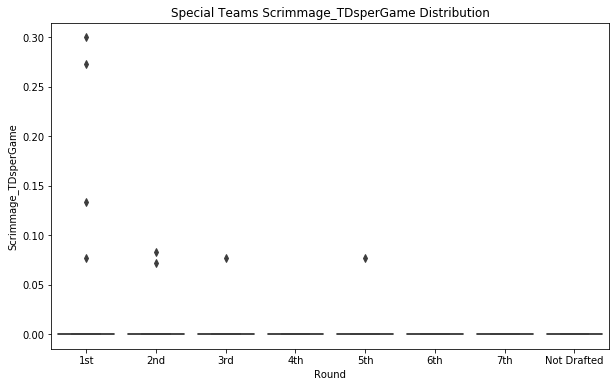

In [24]:
plot_stats('Special Teams', df, rushing_stats)

In [25]:
for i in rushing_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Special Teams', df, i)
    print('')
    print('*' * 40)

Rush_Rec_Games ANOVA Test:
----------------------------------------
             df   sum_sq  mean_sq    F  PR(>F)
Round      7.00   769.13   109.88 7.21    0.00
Residual 996.00 15177.28    15.24  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.3858    0.9 -2.0249 1.2533  False
   1st         3rd  -0.3318    0.9 -1.9014 1.2377  False
   1st         4th    0.159    0.9 -1.4748 1.7929  False
   1st         5th   0.7829 0.8174  -0.867 2.4328  False
   1st         6th   0.8897 0.7068 -0.7714 2.5508  False
   1st         7th  -0.3609    0.9 -2.0278 1.3059  False
   1st Not Drafted   1.7489  0.001  0.5057 2.9921   True
   2nd         3rd    0.054    0.9 -1.6492 1.7572  False
   2nd         4th   0.5448    0.9 -1.2178 2.3074  False
   2nd         5th   1.1687 0.4852 -0.6088 2.9462  False
   2nd         6th   1.2755 0.3744 -0.5125 3.0634

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   -0.008    0.9 -0.0267 0.0107  False
   1st         3rd   -0.008 0.8687 -0.0259 0.0099  False
   1st         4th   -0.008    0.9 -0.0267 0.0107  False
   1st         5th   -0.008    0.9 -0.0268 0.0108  False
   1st         6th   0.0036    0.9 -0.0153 0.0226  False
   1st         7th   -0.008    0.9  -0.027  0.011  False
   1st Not Drafted   -0.008 0.6565 -0.0222 0.0062  False
   2nd         3rd      0.0    0.9 -0.0195 0.0195  False
   2nd         4th      0.0    0.9 -0.0201 0.0201  False
   2nd         5th      0.0    0.9 -0.0203 0.0203  False
   2nd         6th   0.0116 0.6456 -0.0088 0.0321  False
   2nd         7th      0.0    0.9 -0.0205 0.0205  False
   2nd Not Drafted      0.0    0.9 -0.0161 0.0161  False
   3rd         4th      0.0    0.9 -0.0194 0.0194  False
   3rd         5th      0.0    

             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   19.24     2.75 1.17    0.32
Residual 996.00 2349.64     2.36  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.1716    0.9 -0.8165 0.4734  False
   1st         3rd  -0.1874    0.9  -0.805 0.4301  False
   1st         4th  -0.1281    0.9 -0.7709 0.5148  False
   1st         5th  -0.1592    0.9 -0.8084   0.49  False
   1st         6th   0.3421 0.7287 -0.3114 0.9957  False
   1st         7th  -0.1572    0.9  -0.813 0.4987  False
   1st Not Drafted  -0.0693    0.9 -0.5584 0.4199  False
   2nd         3rd  -0.0159    0.9  -0.686 0.6543  False
   2nd         4th   0.0435    0.9 -0.6501  0.737  False
   2nd         5th   0.0124    0.9  -0.687 0.7118  False
   2nd         6th   0.5137  0.342 -0.1898 1.2172  False
   2nd         7th   0.0144    0.9 -0.6912   0.72  False
   2nd

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0626    0.9 -0.4435 0.3182  False
   1st         3rd   -0.068    0.9 -0.4327 0.2967  False
   1st         4th  -0.0224    0.9  -0.402 0.3572  False
   1st         5th  -0.0088    0.9 -0.3922 0.3745  False
   1st         6th   0.2234 0.6284 -0.1625 0.6094  False
   1st         7th  -0.0253    0.9 -0.4126  0.362  False
   1st Not Drafted    0.019    0.9 -0.2699 0.3078  False
   2nd         3rd  -0.0054    0.9 -0.4012 0.3903  False
   2nd         4th   0.0402    0.9 -0.3693 0.4498  False
   2nd         5th   0.0538    0.9 -0.3592 0.4668  False
   2nd         6th    0.286 0.4239 -0.1294 0.7015  False
   2nd         7th   0.0373    0.9 -0.3794  0.454  False
   2nd Not Drafted   0.0816    0.9 -0.2456 0.4088  False
   3rd         4th   0.0456    0.9 -0.3489 0.4402  False
   3rd         5th   0.0592    

             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00    0.29     0.04 1.26    0.27
Residual 996.00   33.31     0.03  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0156    0.9 -0.0924 0.0612  False
   1st         3rd   -0.017    0.9 -0.0905 0.0565  False
   1st         4th  -0.0121    0.9 -0.0886 0.0644  False
   1st         5th  -0.0145    0.9 -0.0918 0.0628  False
   1st         6th   0.0483 0.5515 -0.0295 0.1262  False
   1st         7th  -0.0146    0.9 -0.0927 0.0635  False
   1st Not Drafted  -0.0071    0.9 -0.0653 0.0511  False
   2nd         3rd  -0.0014    0.9 -0.0812 0.0784  False
   2nd         4th   0.0035    0.9  -0.079 0.0861  False
   2nd         5th   0.0011    0.9 -0.0821 0.0844  False
   2nd         6th    0.064 0.2838 -0.0198 0.1477  False
   2nd         7th   0.0011    0.9  -0.083 0.0851  False
   2nd

### College Stats - Defense

In [26]:
defense_stats = ['Defense_Games', 'Solo_Tackles', 'Assisted_Tackles', 'Ttl_Tackles', 'Loss', 'Sacks', 
                 'Defensive_Interceptions', 'Def_Int_Yds', 'Yds_per_Int', 'Pick_6', 'Defended_Passes', 
                 'Recovered_Fumbles', 'Rec_Fumbles_Yds', 'Fumbles_Returned_TD', 'Forced_Fumbles', 
                 'Solo_TacklesperGame', 'Assisted_TacklesperGame', 'Ttl_TacklesperGame', 'LossperGame', 
                 'SacksperGame', 'Defensive_InterceptionsperGame', 'Def_Int_YdsperGame', 'Pick_6perGame', 
                 'Defended_PassesperGame', 'Recovered_FumblesperGame', 'Rec_Fumbles_YdsperGame', 
                 'Fumbles_Returned_TDperGame', 'Forced_FumblesperGame']

In [27]:
df[defense_stats].describe()

,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Solo_TacklesperGame,Assisted_TacklesperGame,Ttl_TacklesperGame,LossperGame,SacksperGame,Defensive_InterceptionsperGame,Def_Int_YdsperGame,Pick_6perGame,Defended_PassesperGame,Recovered_FumblesperGame,Rec_Fumbles_YdsperGame,Fumbles_Returned_TDperGame,Forced_FumblesperGame
count,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00
mean,10.20,15.67,12.99,28.65,6.60,3.36,0.18,2.41,2.07,0.04,0.99,0.24,1.84,0.06,0.61,inf,inf,inf,inf,inf,0.01,0.20,0.00,inf,inf,inf,inf,inf
std,4.61,13.77,11.97,24.17,6.45,3.79,0.44,9.03,7.95,0.19,1.58,0.53,8.82,0.24,1.13,nan,nan,nan,nan,nan,0.04,0.76,0.02,nan,nan,nan,nan,nan
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-5.00,-5.00,0.00,0.00,0.00,-4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.36,0.00,0.00,0.00,-0.36,0.00,0.00
25%,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,12.00,16.00,13.00,33.00,6.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.42,1.15,2.84,0.54,0.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,13.00,26.00,22.00,47.00,11.00,5.50,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,1.00,2.23,1.85,4.00,1.00,0.50,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.08
max,15.00,69.00,61.00,112.00,28.50,20.00,3.00,81.00,81.00,1.00,10.00,3.00,85.00,1.00,9.00,inf,inf,inf,inf,inf,0.33,6.75,0.11,inf,inf,inf,inf,inf


Special Teams Defense_Games Summary:
count   1004.00
mean      10.20
std        4.61
min        0.00
25%       11.00
50%       12.00
75%       13.00
max       15.00
Name: Defense_Games, dtype: float64
----------------------------------------
Special Teams Defense_Games by Round
             Defense_Games
Round                     
1st                  10.44
2nd                  11.78
3rd                  10.99
4th                  10.31
5th                  10.41
6th                   9.59
7th                  10.11
Not Drafted           9.54


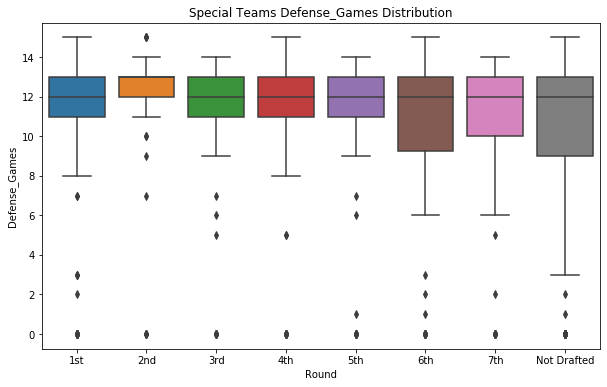

Special Teams Solo_Tackles Summary:
count   1004.00
mean      15.67
std       13.77
min        0.00
25%        0.00
50%       16.00
75%       26.00
max       69.00
Name: Solo_Tackles, dtype: float64
----------------------------------------
Special Teams Solo_Tackles by Round
             Solo_Tackles
Round                    
1st                 23.42
2nd                 23.64
3rd                 21.17
4th                 16.86
5th                 13.10
6th                 12.24
7th                 15.60
Not Drafted         10.14


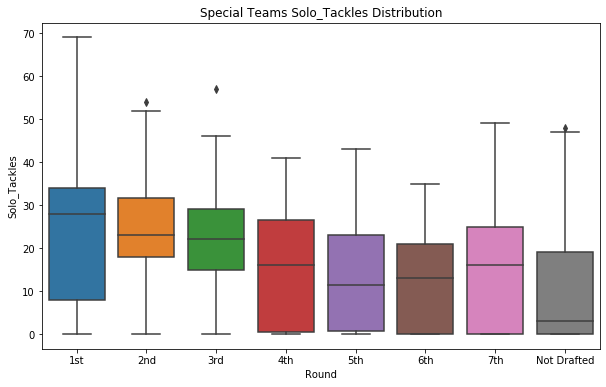

Special Teams Assisted_Tackles Summary:
count   1004.00
mean      12.99
std       11.97
min        0.00
25%        0.00
50%       13.00
75%       22.00
max       61.00
Name: Assisted_Tackles, dtype: float64
----------------------------------------
Special Teams Assisted_Tackles by Round
             Assisted_Tackles
Round                        
1st                     16.83
2nd                     18.64
3rd                     17.84
4th                     14.59
5th                     12.22
6th                     11.50
7th                     12.55
Not Drafted              8.75


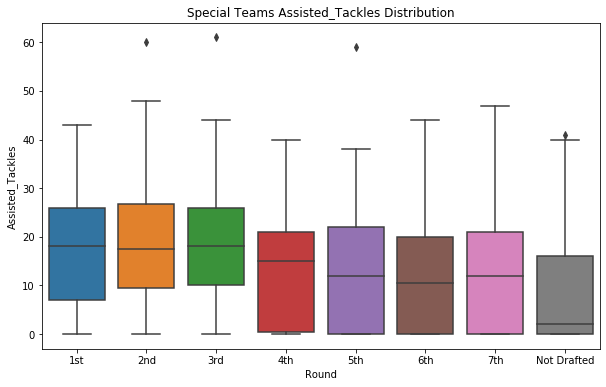

Special Teams Ttl_Tackles Summary:
count   1004.00
mean      28.65
std       24.17
min        0.00
25%        0.00
50%       33.00
75%       47.00
max      112.00
Name: Ttl_Tackles, dtype: float64
----------------------------------------
Special Teams Ttl_Tackles by Round
             Ttl_Tackles
Round                   
1st                40.26
2nd                42.29
3rd                39.01
4th                31.45
5th                25.32
6th                23.74
7th                28.15
Not Drafted        18.89


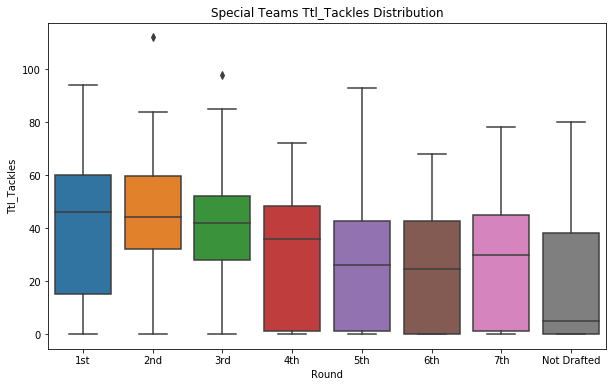

Special Teams Loss Summary:
count   1004.00
mean       6.60
std        6.45
min        0.00
25%        0.00
50%        6.00
75%       11.00
max       28.50
Name: Loss, dtype: float64
----------------------------------------
Special Teams Loss by Round
             Loss
Round            
1st         10.79
2nd         10.59
3rd          9.60
4th          7.07
5th          5.62
6th          4.80
7th          5.84
Not Drafted  3.81


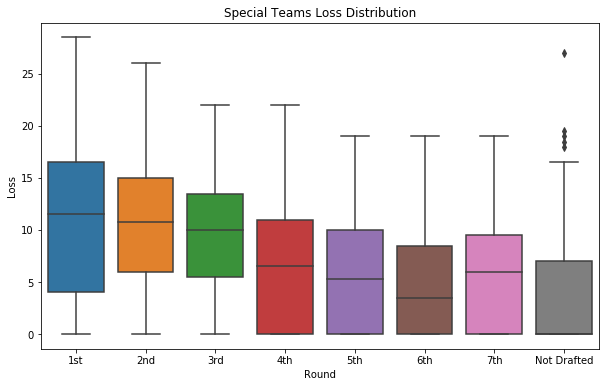

Special Teams Sacks Summary:
count   1004.00
mean       3.36
std        3.79
min        0.00
25%        0.00
50%        2.00
75%        5.50
max       20.00
Name: Sacks, dtype: float64
----------------------------------------
Special Teams Sacks by Round
             Sacks
Round             
1st           5.68
2nd           5.44
3rd           4.96
4th           3.73
5th           2.78
6th           2.44
7th           2.94
Not Drafted   1.81


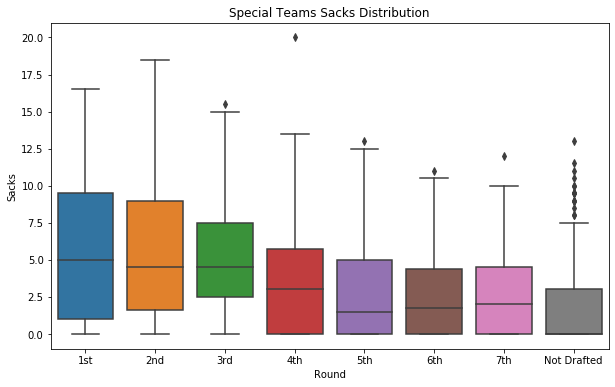

Special Teams Defensive_Interceptions Summary:
count   1004.00
mean       0.18
std        0.44
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        3.00
Name: Defensive_Interceptions, dtype: float64
----------------------------------------
Special Teams Defensive_Interceptions by Round
             Defensive_Interceptions
Round                               
1st                             0.21
2nd                             0.26
3rd                             0.26
4th                             0.22
5th                             0.24
6th                             0.10
7th                             0.11
Not Drafted                     0.13


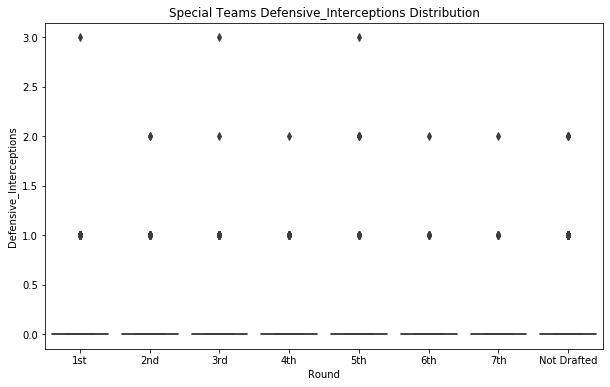

Special Teams Def_Int_Yds Summary:
count   1004.00
mean       2.41
std        9.03
min       -5.00
25%        0.00
50%        0.00
75%        0.00
max       81.00
Name: Def_Int_Yds, dtype: float64
----------------------------------------
Special Teams Def_Int_Yds by Round
             Def_Int_Yds
Round                   
1st                 3.98
2nd                 5.10
3rd                 1.97
4th                 1.66
5th                 2.97
6th                 1.62
7th                 2.12
Not Drafted         1.57


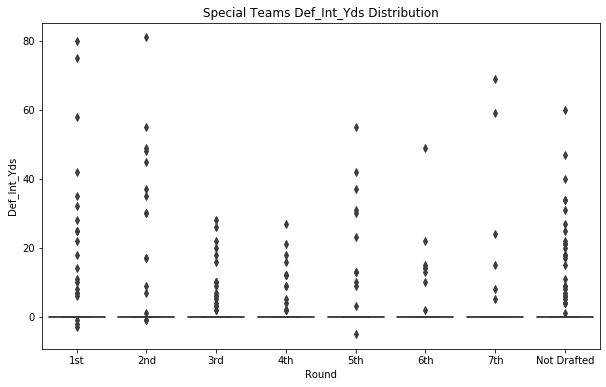

Special Teams Yds_per_Int Summary:
count   1004.00
mean       2.07
std        7.95
min       -5.00
25%        0.00
50%        0.00
75%        0.00
max       81.00
Name: Yds_per_Int, dtype: float64
----------------------------------------
Special Teams Yds_per_Int by Round
             Yds_per_Int
Round                   
1st                 3.15
2nd                 4.81
3rd                 1.89
4th                 1.59
5th                 2.17
6th                 1.33
7th                 1.71
Not Drafted         1.37


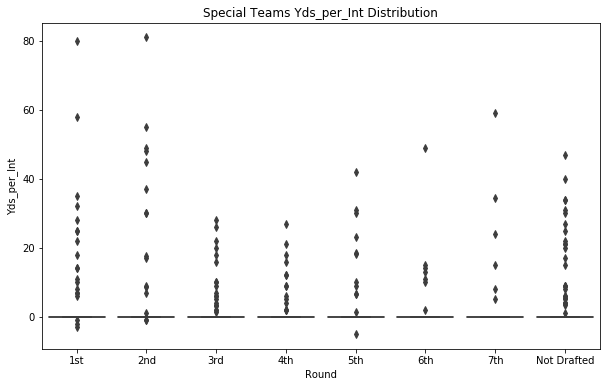

Special Teams Pick_6 Summary:
count   1004.00
mean       0.04
std        0.19
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Pick_6, dtype: float64
----------------------------------------
Special Teams Pick_6 by Round
             Pick_6
Round              
1st            0.06
2nd            0.09
3rd            0.05
4th            0.01
5th            0.06
6th            0.01
7th            0.04
Not Drafted    0.02


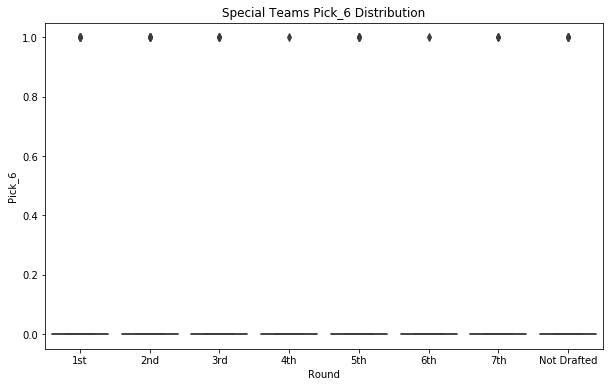

Special Teams Defended_Passes Summary:
count   1004.00
mean       0.99
std        1.58
min        0.00
25%        0.00
50%        0.00
75%        2.00
max       10.00
Name: Defended_Passes, dtype: float64
----------------------------------------
Special Teams Defended_Passes by Round
             Defended_Passes
Round                       
1st                     1.52
2nd                     1.52
3rd                     1.43
4th                     1.36
5th                     0.77
6th                     0.84
7th                     0.84
Not Drafted             0.55


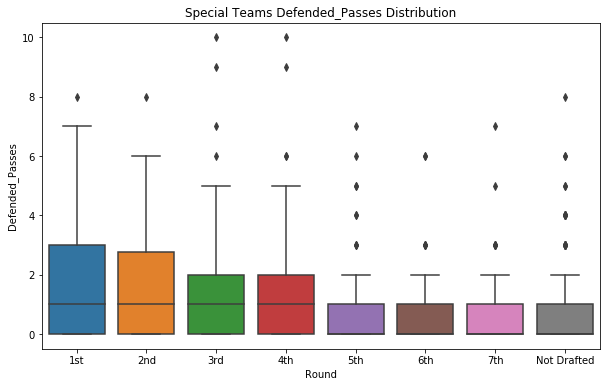

Special Teams Recovered_Fumbles Summary:
count   1004.00
mean       0.24
std        0.53
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        3.00
Name: Recovered_Fumbles, dtype: float64
----------------------------------------
Special Teams Recovered_Fumbles by Round
             Recovered_Fumbles
Round                         
1st                       0.36
2nd                       0.33
3rd                       0.36
4th                       0.27
5th                       0.27
6th                       0.22
7th                       0.25
Not Drafted               0.13


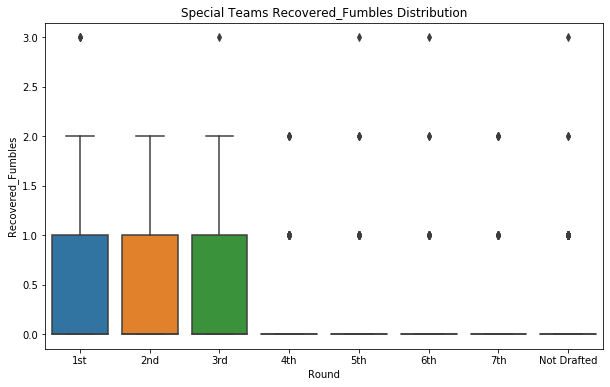

Special Teams Rec_Fumbles_Yds Summary:
count   1004.00
mean       1.84
std        8.82
min       -4.00
25%        0.00
50%        0.00
75%        0.00
max       85.00
Name: Rec_Fumbles_Yds, dtype: float64
----------------------------------------
Special Teams Rec_Fumbles_Yds by Round
             Rec_Fumbles_Yds
Round                       
1st                     3.83
2nd                     2.63
3rd                     1.78
4th                     2.20
5th                     2.50
6th                     1.31
7th                     1.87
Not Drafted             0.77


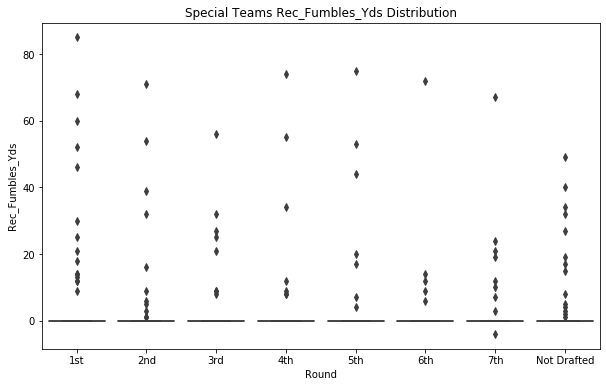

Special Teams Fumbles_Returned_TD Summary:
count   1004.00
mean       0.06
std        0.24
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Fumbles_Returned_TD, dtype: float64
----------------------------------------
Special Teams Fumbles_Returned_TD by Round
             Fumbles_Returned_TD
Round                           
1st                         0.10
2nd                         0.10
3rd                         0.09
4th                         0.05
5th                         0.07
6th                         0.05
7th                         0.06
Not Drafted                 0.03


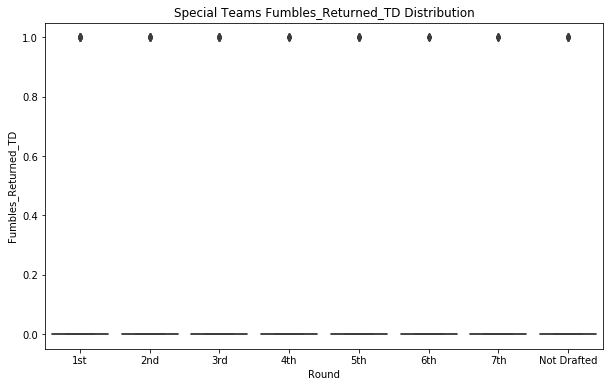

Special Teams Forced_Fumbles Summary:
count   1004.00
mean       0.61
std        1.13
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        9.00
Name: Forced_Fumbles, dtype: float64
----------------------------------------
Special Teams Forced_Fumbles by Round
             Forced_Fumbles
Round                      
1st                    1.02
2nd                    1.10
3rd                    0.88
4th                    0.67
5th                    0.45
6th                    0.55
7th                    0.58
Not Drafted            0.31


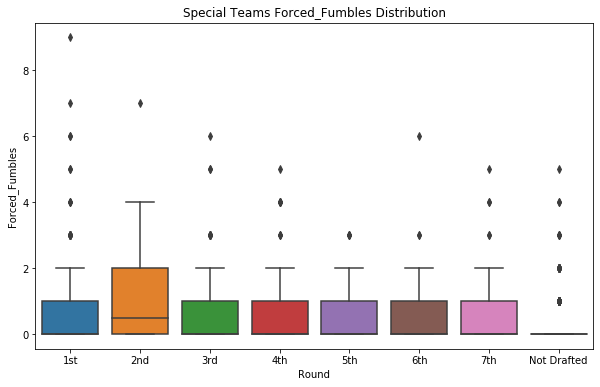

Special Teams Solo_TacklesperGame Summary:
count   1004.00
mean        inf
std         nan
min        0.00
25%        0.00
50%        1.42
75%        2.23
max         inf
Name: Solo_TacklesperGame, dtype: float64
----------------------------------------
Special Teams Solo_TacklesperGame by Round
             Solo_TacklesperGame
Round                           
1st                          inf
2nd                          inf
3rd                          inf
4th                          inf
5th                          inf
6th                          inf
7th                          inf
Not Drafted                  inf


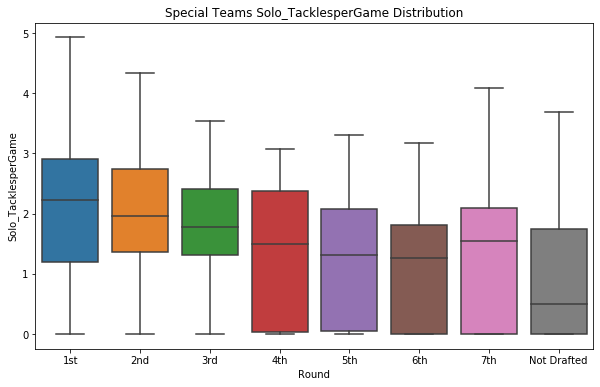

Special Teams Assisted_TacklesperGame Summary:
count   1004.00
mean        inf
std         nan
min        0.00
25%        0.00
50%        1.15
75%        1.85
max         inf
Name: Assisted_TacklesperGame, dtype: float64
----------------------------------------
Special Teams Assisted_TacklesperGame by Round
             Assisted_TacklesperGame
Round                               
1st                              inf
2nd                              inf
3rd                              inf
4th                              inf
5th                              inf
6th                              inf
7th                              inf
Not Drafted                      inf


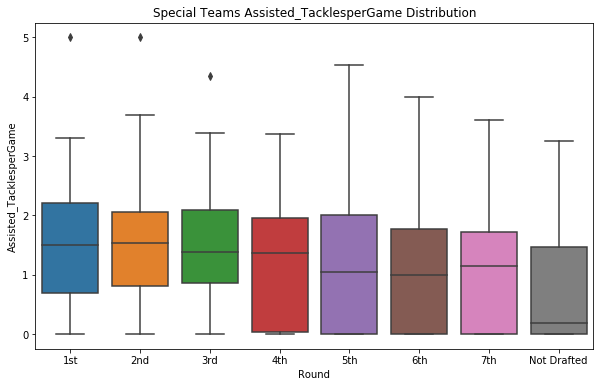

Special Teams Ttl_TacklesperGame Summary:
count   1004.00
mean        inf
std         nan
min        0.00
25%        0.00
50%        2.84
75%        4.00
max         inf
Name: Ttl_TacklesperGame, dtype: float64
----------------------------------------
Special Teams Ttl_TacklesperGame by Round
             Ttl_TacklesperGame
Round                          
1st                         inf
2nd                         inf
3rd                         inf
4th                         inf
5th                         inf
6th                         inf
7th                         inf
Not Drafted                 inf


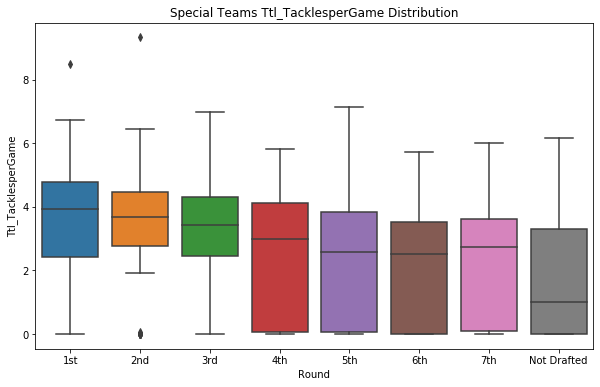

Special Teams LossperGame Summary:
count   1004.00
mean        inf
std         nan
min        0.00
25%        0.00
50%        0.54
75%        1.00
max         inf
Name: LossperGame, dtype: float64
----------------------------------------
Special Teams LossperGame by Round
             LossperGame
Round                   
1st                  inf
2nd                  inf
3rd                  inf
4th                  inf
5th                  inf
6th                  inf
7th                  inf
Not Drafted          inf


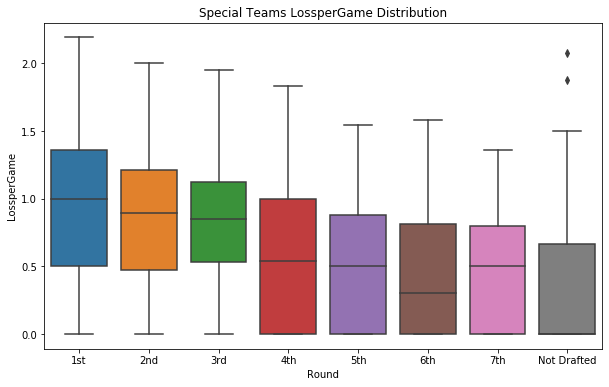

Special Teams SacksperGame Summary:
count   1004.00
mean        inf
std         nan
min        0.00
25%        0.00
50%        0.21
75%        0.50
max         inf
Name: SacksperGame, dtype: float64
----------------------------------------
Special Teams SacksperGame by Round
             SacksperGame
Round                    
1st                   inf
2nd                   inf
3rd                   inf
4th                   inf
5th                   inf
6th                   inf
7th                   inf
Not Drafted           inf


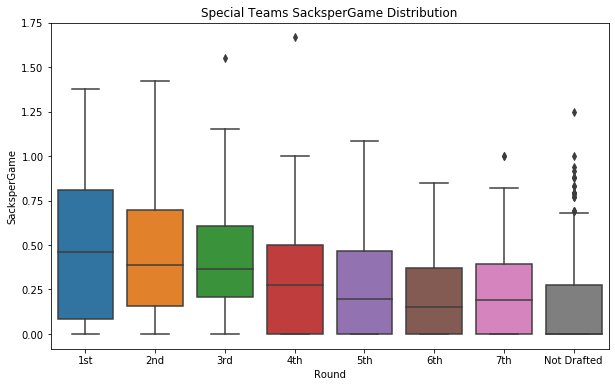

Special Teams Defensive_InterceptionsperGame Summary:
count   1004.00
mean       0.01
std        0.04
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.33
Name: Defensive_InterceptionsperGame, dtype: float64
----------------------------------------
Special Teams Defensive_InterceptionsperGame by Round
             Defensive_InterceptionsperGame
Round                                      
1st                                    0.02
2nd                                    0.02
3rd                                    0.02
4th                                    0.02
5th                                    0.02
6th                                    0.01
7th                                    0.01
Not Drafted                            0.01


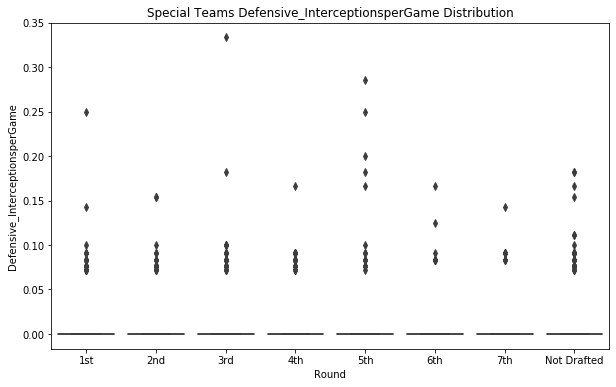

Special Teams Def_Int_YdsperGame Summary:
count   1004.00
mean       0.20
std        0.76
min       -0.36
25%        0.00
50%        0.00
75%        0.00
max        6.75
Name: Def_Int_YdsperGame, dtype: float64
----------------------------------------
Special Teams Def_Int_YdsperGame by Round
             Def_Int_YdsperGame
Round                          
1st                        0.34
2nd                        0.39
3rd                        0.16
4th                        0.14
5th                        0.26
6th                        0.16
7th                        0.18
Not Drafted                0.13


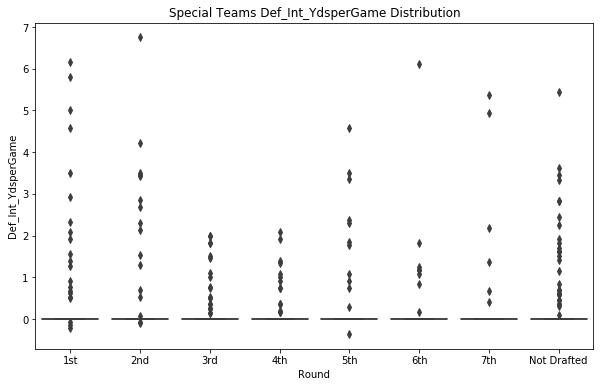

Special Teams Pick_6perGame Summary:
count   1004.00
mean       0.00
std        0.02
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.11
Name: Pick_6perGame, dtype: float64
----------------------------------------
Special Teams Pick_6perGame by Round
             Pick_6perGame
Round                     
1st                   0.00
2nd                   0.01
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


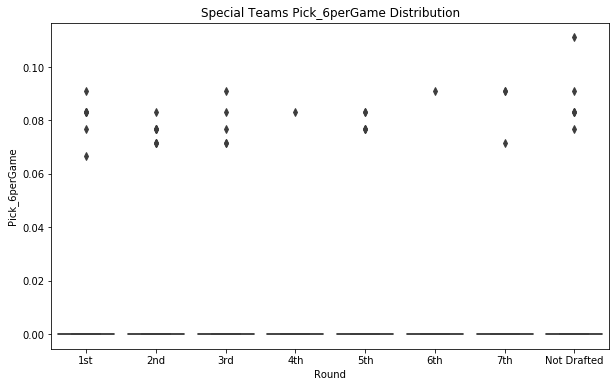

Special Teams Defended_PassesperGame Summary:
count   1004.00
mean        inf
std         nan
min        0.00
25%        0.00
50%        0.00
75%        0.15
max         inf
Name: Defended_PassesperGame, dtype: float64
----------------------------------------
Special Teams Defended_PassesperGame by Round
             Defended_PassesperGame
Round                              
1st                             inf
2nd                             inf
3rd                             inf
4th                             inf
5th                             inf
6th                             inf
7th                             inf
Not Drafted                     inf


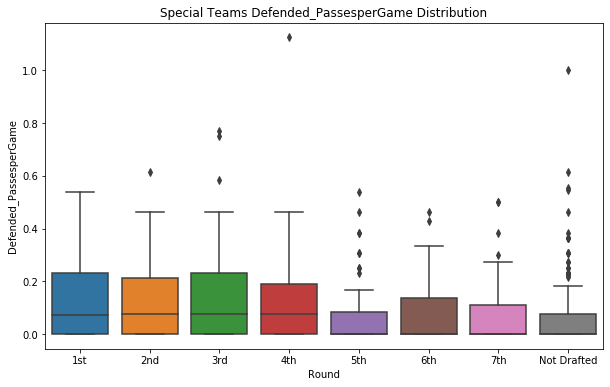

Special Teams Recovered_FumblesperGame Summary:
count   1004.00
mean        inf
std         nan
min        0.00
25%        0.00
50%        0.00
75%        0.00
max         inf
Name: Recovered_FumblesperGame, dtype: float64
----------------------------------------
Special Teams Recovered_FumblesperGame by Round
             Recovered_FumblesperGame
Round                                
1st                               inf
2nd                              0.03
3rd                              0.03
4th                              0.02
5th                               inf
6th                              0.02
7th                              0.02
Not Drafted                      0.01


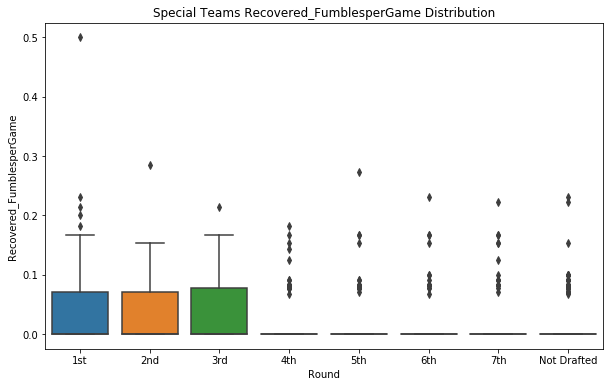

Special Teams Rec_Fumbles_YdsperGame Summary:
count   1004.00
mean        inf
std         nan
min       -0.36
25%        0.00
50%        0.00
75%        0.00
max         inf
Name: Rec_Fumbles_YdsperGame, dtype: float64
----------------------------------------
Special Teams Rec_Fumbles_YdsperGame by Round
             Rec_Fumbles_YdsperGame
Round                              
1st                             inf
2nd                            0.21
3rd                            0.15
4th                            0.19
5th                             inf
6th                            0.11
7th                            0.15
Not Drafted                    0.07


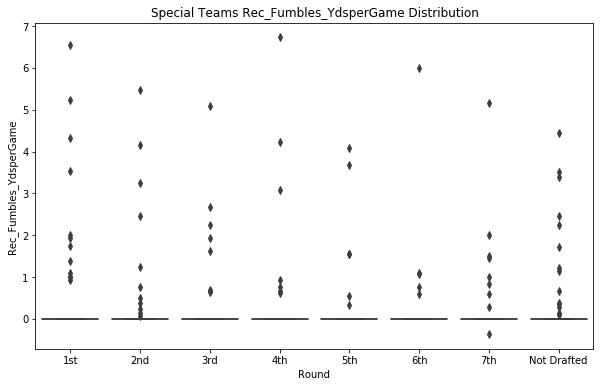

Special Teams Fumbles_Returned_TDperGame Summary:
count   1004.00
mean        inf
std         nan
min        0.00
25%        0.00
50%        0.00
75%        0.00
max         inf
Name: Fumbles_Returned_TDperGame, dtype: float64
----------------------------------------
Special Teams Fumbles_Returned_TDperGame by Round
             Fumbles_Returned_TDperGame
Round                                  
1st                                0.01
2nd                                0.01
3rd                                0.01
4th                                0.00
5th                                 inf
6th                                0.00
7th                                0.00
Not Drafted                        0.00


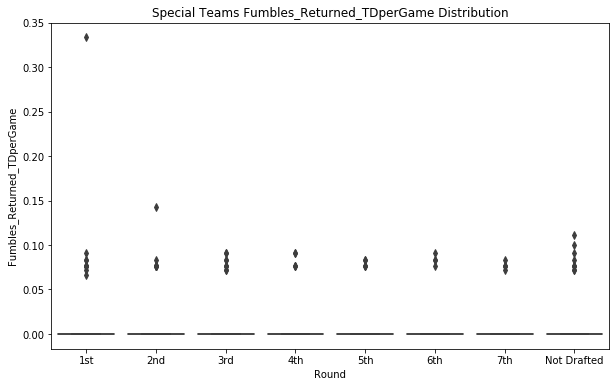

Special Teams Forced_FumblesperGame Summary:
count   1004.00
mean        inf
std         nan
min        0.00
25%        0.00
50%        0.00
75%        0.08
max         inf
Name: Forced_FumblesperGame, dtype: float64
----------------------------------------
Special Teams Forced_FumblesperGame by Round
             Forced_FumblesperGame
Round                             
1st                            inf
2nd                            inf
3rd                            inf
4th                            inf
5th                            inf
6th                            inf
7th                           0.05
Not Drafted                    inf


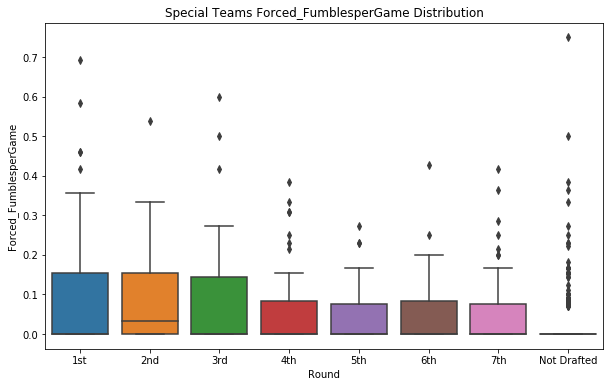

In [28]:
plot_stats('Special Teams', df, defense_stats)

In [29]:
for i in defense_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Special Teams', df, i)
    print('')
    print('*' * 40)

Defense_Games ANOVA Test:
----------------------------------------
             df   sum_sq  mean_sq    F  PR(>F)
Round      7.00   481.48    68.78 3.29    0.00
Residual 996.00 20835.88    20.92  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd   1.3378 0.4077 -0.5827  3.2583  False
   1st         3rd   0.5505    0.9 -1.2885  2.3895  False
   1st         4th  -0.1323    0.9 -2.0467   1.782  False
   1st         5th  -0.0309    0.9  -1.964  1.9022  False
   1st         6th   -0.847 0.8887 -2.7933  1.0993  False
   1st         7th  -0.3341    0.9 -2.2872  1.6189  False
   1st Not Drafted  -0.9041 0.5527 -2.3607  0.5526  False
   2nd         3rd  -0.7873    0.9 -2.7829  1.2083  False
   2nd         4th  -1.4701 0.3775 -3.5353  0.5951  False
   2nd         5th  -1.3687 0.4858 -3.4513   0.714  False
   2nd         6th  -2.1848 0.0339 -4

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd  -0.2371    0.9 -1.7038  1.2296  False
   1st         3rd  -0.7189 0.7498 -2.1233  0.6856  False
   1st         4th  -1.9507 0.0014 -3.4127 -0.4887   True
   1st         5th  -2.8976  0.001 -4.3739 -1.4212   True
   1st         6th  -3.2341  0.001 -4.7205 -1.7477   True
   1st         7th  -2.7348  0.001 -4.2264 -1.2433   True
   1st Not Drafted  -3.8631  0.001 -4.9756 -2.7507   True
   2nd         3rd  -0.4817    0.9 -2.0058  1.0423  False
   2nd         4th  -1.7136 0.0223 -3.2908 -0.1364   True
   2nd         5th  -2.6605  0.001  -4.251 -1.0699   True
   2nd         6th   -2.997  0.001 -4.5969 -1.3972   True
   2nd         7th  -2.4977  0.001 -4.1024  -0.893   True
   2nd Not Drafted   -3.626  0.001 -4.8861  -2.366   True
   3rd         4th  -1.2319  0.213 -2.7514  0.2877  False
   3rd        

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd   0.0329    0.9 -0.0448  0.1106  False
   1st         3rd  -0.0084    0.9 -0.0828  0.0661  False
   1st         4th   -0.045 0.6248 -0.1225  0.0325  False
   1st         5th   0.0008    0.9 -0.0774  0.0791  False
   1st         6th  -0.0444 0.6567 -0.1232  0.0344  False
   1st         7th  -0.0207    0.9 -0.0998  0.0583  False
   1st Not Drafted   -0.038 0.5084  -0.097  0.0209  False
   2nd         3rd  -0.0413 0.7515  -0.122  0.0395  False
   2nd         4th  -0.0779 0.0885 -0.1615  0.0057  False
   2nd         5th  -0.0321    0.9 -0.1164  0.0522  False
   2nd         6th  -0.0773 0.1045 -0.1621  0.0075  False
   2nd         7th  -0.0536 0.5355 -0.1386  0.0315  False
   2nd Not Drafted  -0.0709 0.0283 -0.1377 -0.0041   True
   3rd         4th  -0.0366 0.8531 -0.1172  0.0439  False
   3rd        

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd    0.004    0.9 -0.0945 0.1025  False
   1st         3rd  -0.0103    0.9 -0.1046  0.084  False
   1st         4th  -0.0411    0.9 -0.1392 0.0571  False
   1st         5th  -0.0278    0.9 -0.1269 0.0713  False
   1st         6th  -0.0495 0.7786 -0.1493 0.0503  False
   1st         7th  -0.0372    0.9 -0.1373  0.063  False
   1st Not Drafted  -0.0691 0.0938 -0.1437 0.0056  False
   2nd         3rd  -0.0143    0.9 -0.1166  0.088  False
   2nd         4th  -0.0451    0.9 -0.1509 0.0608  False
   2nd         5th  -0.0318    0.9 -0.1386  0.075  False
   2nd         6th  -0.0535 0.7749 -0.1609 0.0539  False
   2nd         7th  -0.0412    0.9 -0.1489 0.0666  False
   2nd Not Drafted  -0.0731 0.1487 -0.1576 0.0115  False
   3rd         4th  -0.0308    0.9 -0.1328 0.0712  False
   3rd         5th  -0.0175    


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      nan 0.5566   nan   nan  False
   1st         3rd      nan 0.5566   nan   nan  False
   1s

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd    0.003    0.9  -0.013 0.0189  False
   1st         3rd   0.0051    0.9 -0.0101 0.0204  False
   1st         4th   0.0008    0.9 -0.0151 0.0166  False
   1st         5th   0.0045    0.9 -0.0115 0.0205  False
   1st         6th   -0.008 0.7794 -0.0241 0.0081  False
   1st         7th  -0.0084 0.7385 -0.0246 0.0078  False
   1st Not Drafted  -0.0065 0.6983 -0.0186 0.0056  False
   2nd         3rd   0.0022    0.9 -0.0144 0.0187  False
   2nd         4th  -0.0022    0.9 -0.0193 0.0149  False
   2nd         5th   0.0015    0.9 -0.0157 0.0188  False
   2nd         6th   -0.011 0.5337 -0.0283 0.0064  False
   2nd         7th  -0.0114  0.496 -0.0288 0.0061  False
   2nd Not Drafted  -0.0095 0.4133 -0.0232 0.0042  False
   3rd         4th  -0.0044    0.9 -0.0209 0.0121  False
   3rd         5th  -0.0006    

             df  sum_sq  mean_sq   F  PR(>F)
Round      7.00     nan      nan nan     nan
Residual 996.00     nan      nan nan     nan


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-------------------------------


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      nan 0.5566   nan   nan  False
   1st         3rd      nan 0.5566   nan   nan  False
   1st         4th      nan 0.5566   nan   nan  False
   1st         5th      nan 0.5566   nan   nan  False
   1st         6th    

### College Stats - Kicking

In [30]:
kicking_stats = ['Kicking_Games', 'XP_Made', 'XP_Attempts', 'XP_Percent', 'FG_Made', 'FG_Attempts', 'FG_Percent', 
                 'TTL_Kicking_Points', 'NumPunts', 'Punt_Yds', 'Yds_per_Punt', 'XP_MadeperGame', 'XP_AttemptsperGame',
                 'FG_MadeperGame', 'FG_AttemptsperGame', 'TTL_Kicking_PointsperGame', 'NumPuntsperGame', 
                 'Punt_YdsperGame']

In [31]:
df[kicking_stats].describe()

,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame
count,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00
mean,1.04,3.37,3.44,8.08,1.53,1.94,6.48,7.95,0.86,35.99,1.10,0.27,0.27,0.12,0.16,0.64,0.07,2.99
std,3.46,12.00,12.24,26.94,5.34,6.73,21.80,27.50,6.66,280.16,6.57,0.94,0.96,0.43,0.54,2.18,0.55,22.97
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,14.00,87.00,88.00,100.00,30.00,35.00,95.20,156.00,81.00,3259.00,48.10,6.21,6.29,2.23,2.73,12.00,6.23,271.58


Special Teams Kicking_Games Summary:
count   1004.00
mean       1.04
std        3.46
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       14.00
Name: Kicking_Games, dtype: float64
----------------------------------------
Special Teams Kicking_Games by Round
             Kicking_Games
Round                     
1st                   0.09
2nd                   0.28
3rd                   0.12
4th                   0.40
5th                   1.35
6th                   1.05
7th                   0.88
Not Drafted           2.02


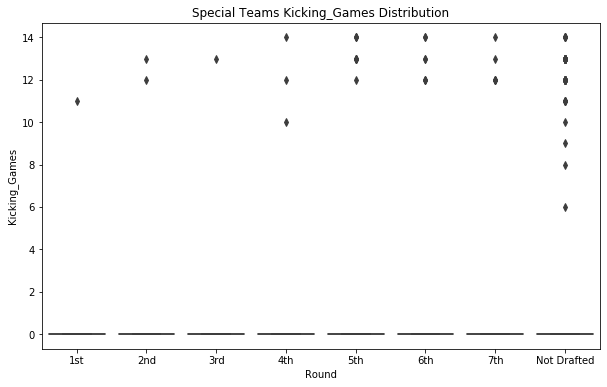

Special Teams XP_Made Summary:
count   1004.00
mean       3.37
std       12.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       87.00
Name: XP_Made, dtype: float64
----------------------------------------
Special Teams XP_Made by Round
             XP_Made
Round               
1st             0.38
2nd             0.88
3rd             0.38
4th             1.32
5th             5.24
6th             3.13
7th             2.26
Not Drafted     6.51


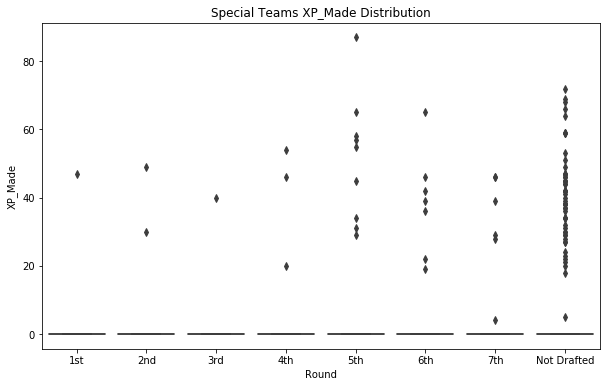

Special Teams XP_Attempts Summary:
count   1004.00
mean       3.44
std       12.24
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       88.00
Name: XP_Attempts, dtype: float64
----------------------------------------
Special Teams XP_Attempts by Round
             XP_Attempts
Round                   
1st                 0.38
2nd                 0.88
3rd                 0.39
4th                 1.40
5th                 5.30
6th                 3.15
7th                 2.27
Not Drafted         6.68


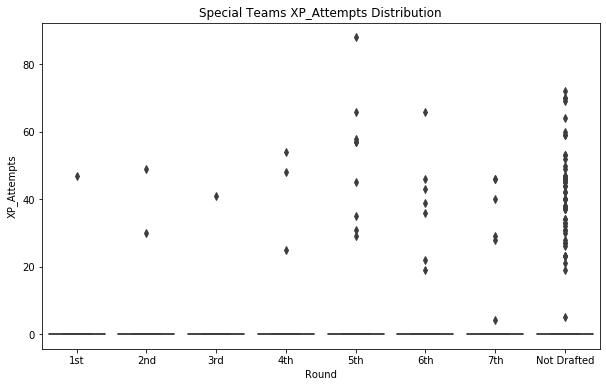

Special Teams XP_Percent Summary:
count   1004.00
mean       8.08
std       26.94
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      100.00
Name: XP_Percent, dtype: float64
----------------------------------------
Special Teams XP_Percent by Round
             XP_Percent
Round                  
1st                0.80
2nd                2.22
3rd                0.93
4th                3.03
5th               10.12
6th                8.10
7th                7.03
Not Drafted       15.72


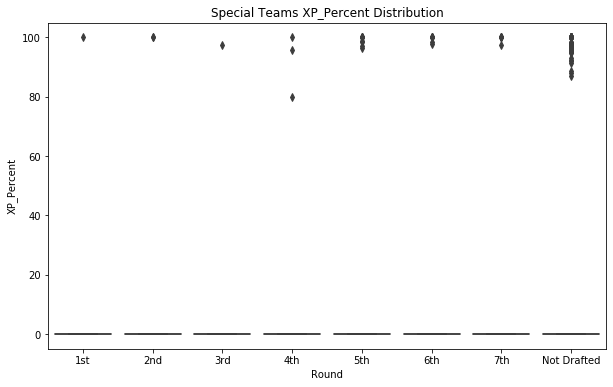

Special Teams FG_Made Summary:
count   1004.00
mean       1.53
std        5.34
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       30.00
Name: FG_Made, dtype: float64
----------------------------------------
Special Teams FG_Made by Round
             FG_Made
Round               
1st             0.18
2nd             0.50
3rd             0.19
4th             0.65
5th             2.25
6th             1.66
7th             1.01
Not Drafted     2.87


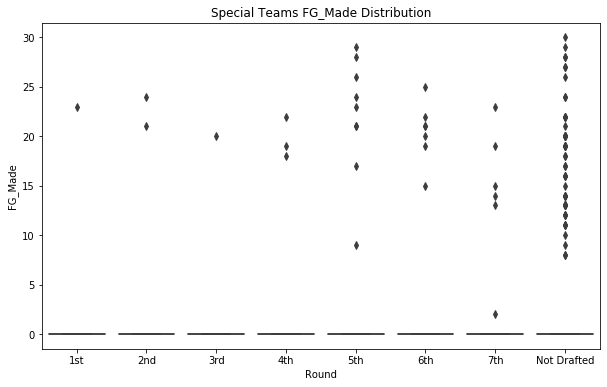

Special Teams FG_Attempts Summary:
count   1004.00
mean       1.94
std        6.73
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       35.00
Name: FG_Attempts, dtype: float64
----------------------------------------
Special Teams FG_Attempts by Round
             FG_Attempts
Round                   
1st                 0.24
2nd                 0.59
3rd                 0.20
4th                 0.75
5th                 2.77
6th                 2.29
7th                 1.22
Not Drafted         3.68


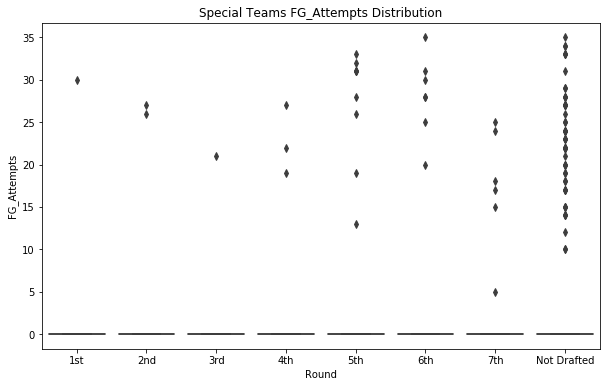

Special Teams FG_Percent Summary:
count   1004.00
mean       6.48
std       21.80
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       95.20
Name: FG_Percent, dtype: float64
----------------------------------------
Special Teams FG_Percent by Round
             FG_Percent
Round                  
1st                0.61
2nd                1.89
3rd                0.91
4th                2.89
5th                8.25
6th                5.96
7th                5.46
Not Drafted       12.57


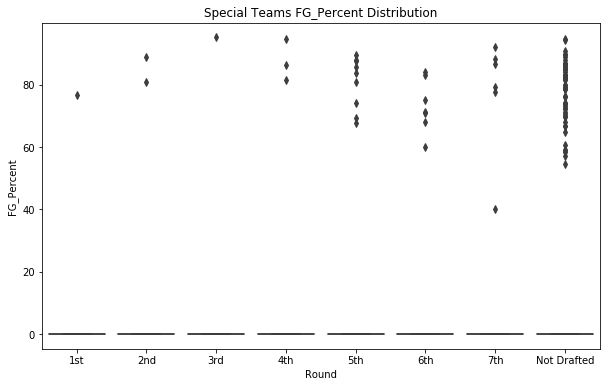

Special Teams TTL_Kicking_Points Summary:
count   1004.00
mean       7.95
std       27.50
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      156.00
Name: TTL_Kicking_Points, dtype: float64
----------------------------------------
Special Teams TTL_Kicking_Points by Round
             TTL_Kicking_Points
Round                          
1st                        0.93
2nd                        2.38
3rd                        0.95
4th                        3.26
5th                       11.99
6th                        8.12
7th                        5.29
Not Drafted               15.11


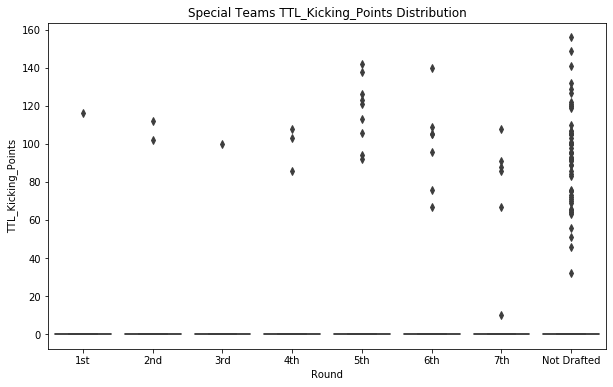

Special Teams NumPunts Summary:
count   1004.00
mean       0.86
std        6.66
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       81.00
Name: NumPunts, dtype: float64
----------------------------------------
Special Teams NumPunts by Round
             NumPunts
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              1.34
5th              0.35
6th              0.93
7th              0.00
Not Drafted      1.90


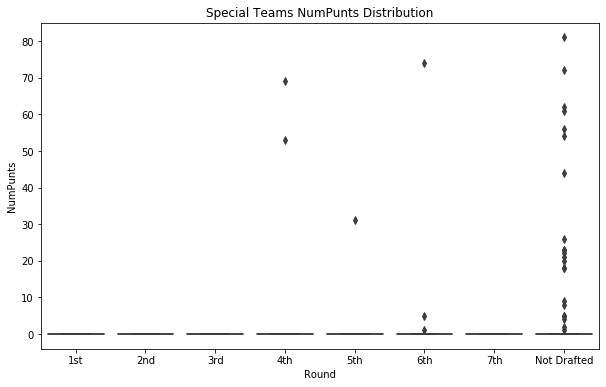

Special Teams Punt_Yds Summary:
count   1004.00
mean      35.99
std      280.16
min        0.00
25%        0.00
50%        0.00
75%        0.00
max     3259.00
Name: Punt_Yds, dtype: float64
----------------------------------------
Special Teams Punt_Yds by Round
             Punt_Yds
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th             60.76
5th             14.40
6th             40.40
7th              0.00
Not Drafted     77.43


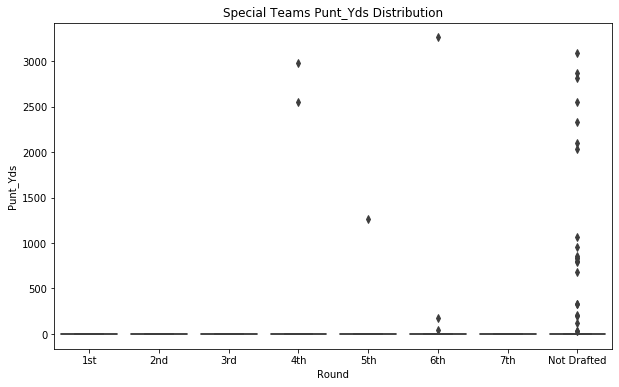

Special Teams Yds_per_Punt Summary:
count   1004.00
mean       1.10
std        6.57
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       48.10
Name: Yds_per_Punt, dtype: float64
----------------------------------------
Special Teams Yds_per_Punt by Round
             Yds_per_Punt
Round                    
1st                  0.00
2nd                  0.00
3rd                  0.00
4th                  1.00
5th                  0.46
6th                  1.41
7th                  0.00
Not Drafted          2.55


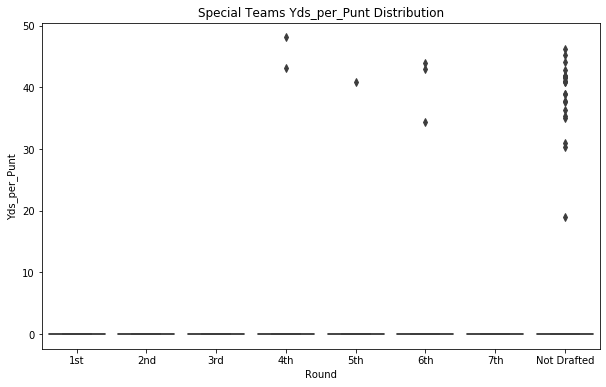

Special Teams XP_MadeperGame Summary:
count   1004.00
mean       0.27
std        0.94
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        6.21
Name: XP_MadeperGame, dtype: float64
----------------------------------------
Special Teams XP_MadeperGame by Round
             XP_MadeperGame
Round                      
1st                    0.03
2nd                    0.07
3rd                    0.03
4th                    0.11
5th                    0.39
6th                    0.24
7th                    0.18
Not Drafted            0.52


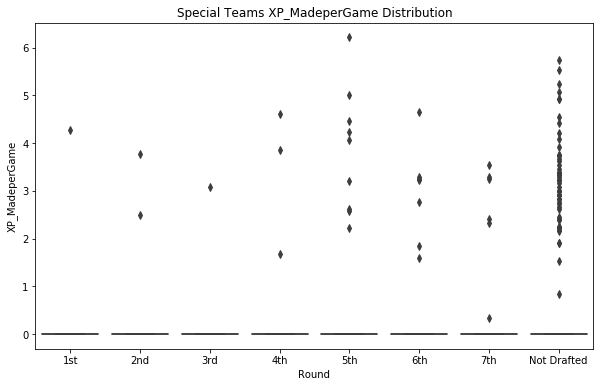

Special Teams XP_AttemptsperGame Summary:
count   1004.00
mean       0.27
std        0.96
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        6.29
Name: XP_AttemptsperGame, dtype: float64
----------------------------------------
Special Teams XP_AttemptsperGame by Round
             XP_AttemptsperGame
Round                          
1st                        0.03
2nd                        0.07
3rd                        0.03
4th                        0.12
5th                        0.40
6th                        0.24
7th                        0.18
Not Drafted                0.54


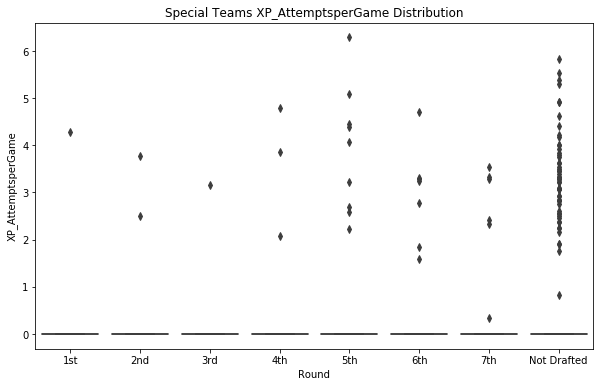

Special Teams FG_MadeperGame Summary:
count   1004.00
mean       0.12
std        0.43
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.23
Name: FG_MadeperGame, dtype: float64
----------------------------------------
Special Teams FG_MadeperGame by Round
             FG_MadeperGame
Round                      
1st                    0.02
2nd                    0.04
3rd                    0.01
4th                    0.06
5th                    0.17
6th                    0.13
7th                    0.08
Not Drafted            0.23


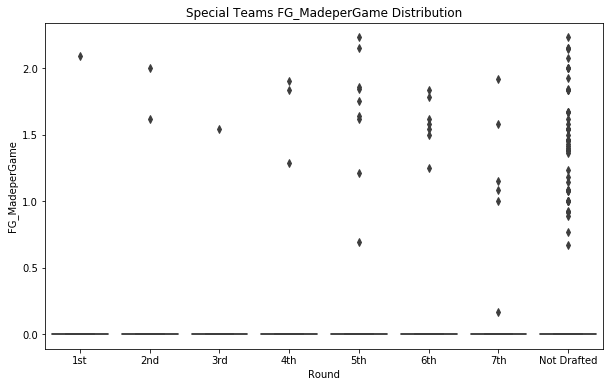

Special Teams FG_AttemptsperGame Summary:
count   1004.00
mean       0.16
std        0.54
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.73
Name: FG_AttemptsperGame, dtype: float64
----------------------------------------
Special Teams FG_AttemptsperGame by Round
             FG_AttemptsperGame
Round                          
1st                        0.02
2nd                        0.05
3rd                        0.02
4th                        0.06
5th                        0.21
6th                        0.18
7th                        0.10
Not Drafted                0.30


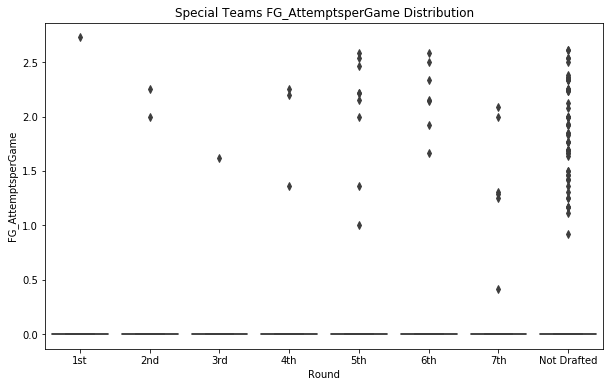

Special Teams TTL_Kicking_PointsperGame Summary:
count   1004.00
mean       0.64
std        2.18
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       12.00
Name: TTL_Kicking_PointsperGame, dtype: float64
----------------------------------------
Special Teams TTL_Kicking_PointsperGame by Round
             TTL_Kicking_PointsperGame
Round                                 
1st                               0.08
2nd                               0.19
3rd                               0.07
4th                               0.28
5th                               0.90
6th                               0.63
7th                               0.42
Not Drafted                       1.22


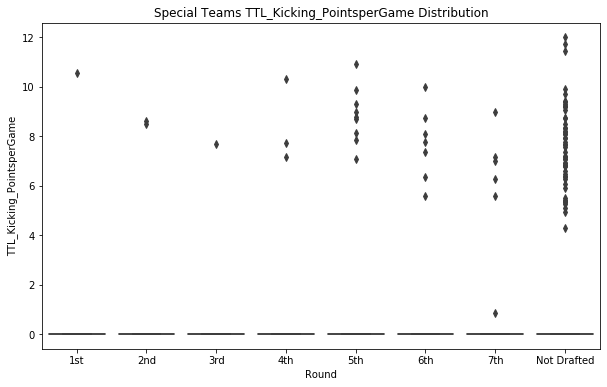

Special Teams NumPuntsperGame Summary:
count   1004.00
mean       0.07
std        0.55
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        6.23
Name: NumPuntsperGame, dtype: float64
----------------------------------------
Special Teams NumPuntsperGame by Round
             NumPuntsperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.10
5th                     0.03
6th                     0.08
7th                     0.00
Not Drafted             0.16


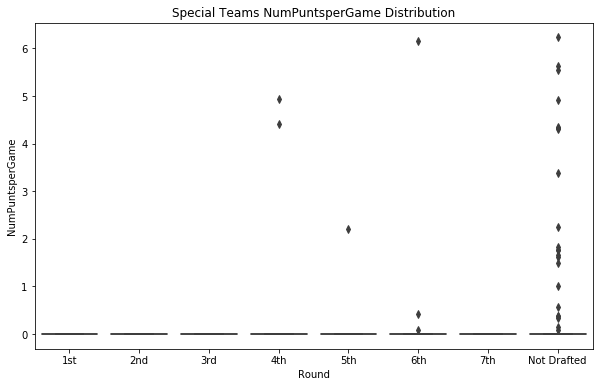

Special Teams Punt_YdsperGame Summary:
count   1004.00
mean       2.99
std       22.97
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      271.58
Name: Punt_YdsperGame, dtype: float64
----------------------------------------
Special Teams Punt_YdsperGame by Round
             Punt_YdsperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     4.67
5th                     1.03
6th                     3.37
7th                     0.00
Not Drafted             6.58


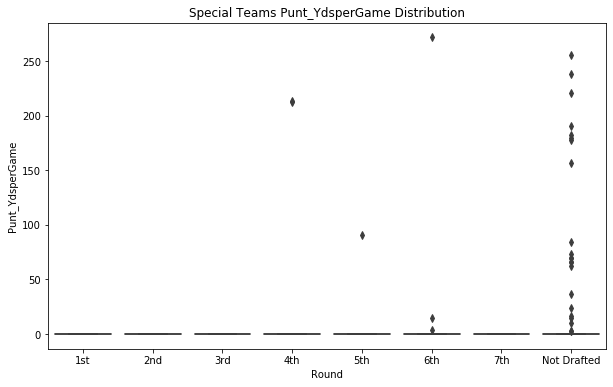

In [32]:
plot_stats('Special Teams', df, kicking_stats)

In [33]:
for i in kicking_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Special Teams', df, i)
    print('')
    print('*' * 40)

Kicking_Games ANOVA Test:
----------------------------------------
             df   sum_sq  mean_sq    F  PR(>F)
Round      7.00   621.64    88.81 7.77    0.00
Residual 996.00 11387.85    11.43  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.1898    0.9   -1.23 1.6096  False
   1st         3rd   0.0358    0.9 -1.3238 1.3954  False
   1st         4th   0.3076    0.9 -1.1077 1.7229  False
   1st         5th   1.2643 0.1272 -0.1649 2.6934  False
   1st         6th   0.9585 0.4684 -0.4804 2.3974  False
   1st         7th   0.7944 0.6804 -0.6495 2.2382  False
   1st Not Drafted     1.93  0.001  0.8531 3.0068   True
   2nd         3rd   -0.154    0.9 -1.6293 1.3213  False
   2nd         4th   0.1178    0.9  -1.409 1.6446  False
   2nd         5th   1.0745 0.4052 -0.4652 2.6142  False
   2nd         6th   0.7687 0.7778   -0.78 2.3174 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.3489    0.9 -2.4198 3.1176  False
   1st         3rd    -0.04    0.9 -2.6912 2.6112  False
   1st         4th   0.5073    0.9 -2.2526 3.2671  False
   1st         5th   2.5327 0.1065 -0.2542 5.3197  False
   1st         6th   2.0507 0.3408 -0.7552 4.8566  False
   1st         7th   0.9835    0.9 -1.8321 3.7992  False
   1st Not Drafted   3.4426  0.001  1.3427 5.5426   True
   2nd         3rd  -0.3889    0.9 -3.2658 2.4881  False
   2nd         4th   0.1584    0.9  -2.819 3.1357  False
   2nd         5th   2.1838 0.3475 -0.8186 5.1863  False
   2nd         6th   1.7018 0.6562 -1.3183 4.7219  False
   2nd         7th   0.6346    0.9 -2.3945 3.6638  False
   2nd Not Drafted   3.0937 0.0021  0.7152 5.4723   True
   3rd         4th   0.5473    0.9 -2.3212 3.4157  False
   3rd         5th   2.5727 0.1

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd      0.0    0.9 -2.7273 2.7273  False
   1st         3rd      0.0    0.9 -2.6116 2.6116  False
   1st         4th   1.0033    0.9 -1.7153 3.7219  False
   1st         5th   0.4648    0.9 -2.2805   3.21  False
   1st         6th   1.4116 0.7518 -1.3523 4.1756  False
   1st         7th      0.0    0.9 -2.7736 2.7736  False
   1st Not Drafted   2.5467 0.0048  0.4781 4.6153   True
   2nd         3rd      0.0    0.9  -2.834  2.834  False
   2nd         4th   1.0033    0.9 -1.9295 3.9361  False
   2nd         5th   0.4648    0.9 -2.4928 3.4224  False
   2nd         6th   1.4116 0.8174 -1.5633 4.3866  False
   2nd         7th      0.0    0.9 -2.9839 2.9839  False
   2nd Not Drafted   2.5467 0.0222  0.2037 4.8897   True
   3rd         4th   1.0033    0.9 -1.8223 3.8289  False
   3rd         5th   0.4648    

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.0254    0.9 -0.1959 0.2467  False
   1st         3rd  -0.0064    0.9 -0.2184 0.2055  False
   1st         4th    0.042    0.9 -0.1786 0.2626  False
   1st         5th   0.1887 0.1675 -0.0341 0.4114  False
   1st         6th   0.1561 0.4088 -0.0682 0.3804  False
   1st         7th   0.0763    0.9 -0.1487 0.3014  False
   1st Not Drafted    0.278  0.001  0.1102 0.4459   True
   2nd         3rd  -0.0318    0.9 -0.2618 0.1981  False
   2nd         4th   0.0166    0.9 -0.2214 0.2546  False
   2nd         5th   0.1633 0.4405 -0.0767 0.4033  False
   2nd         6th   0.1307 0.6961 -0.1107 0.3721  False
   2nd         7th   0.0509    0.9 -0.1912 0.2931  False
   2nd Not Drafted   0.2526 0.0015  0.0625 0.4428   True
   3rd         4th   0.0484    0.9 -0.1809 0.2777  False
   3rd         5th   0.1951 0.1

### College Stats - Punt Returns

In [34]:
puntret_stats = ['PuntRet_Games', 'Kickoff_Returns', 'KO_Return_Yds', 'Yds_per_KO_Return', 'KO_Returned_for_TD', 
                 'Kickoff_ReturnsperGame', 'KO_Return_YdsperGame', 'KO_Returned_for_TDperGame']

In [35]:
df[puntret_stats].describe()

,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame
count,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00
mean,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,1.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,14.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Special Teams PuntRet_Games Summary:
count   1004.00
mean       0.33
std        1.95
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       14.00
Name: PuntRet_Games, dtype: float64
----------------------------------------
Special Teams PuntRet_Games by Round
             PuntRet_Games
Round                     
1st                   0.78
2nd                   0.43
3rd                   0.43
4th                   0.38
5th                   0.14
6th                   0.13
7th                   0.51
Not Drafted           0.15


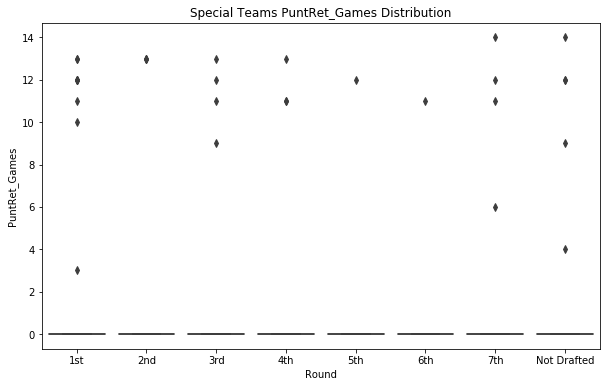

Special Teams Kickoff_Returns Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: Kickoff_Returns, dtype: float64
----------------------------------------
Special Teams Kickoff_Returns by Round
             Kickoff_Returns
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


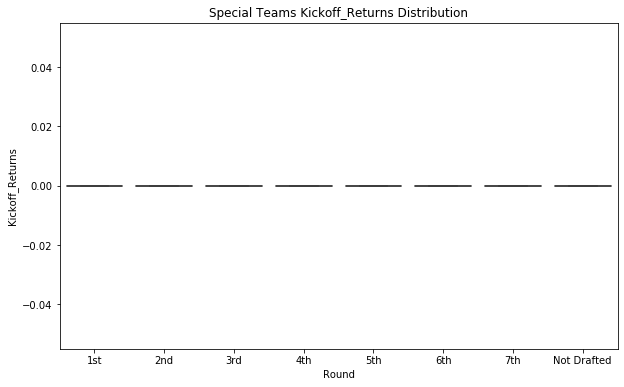

Special Teams KO_Return_Yds Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: KO_Return_Yds, dtype: float64
----------------------------------------
Special Teams KO_Return_Yds by Round
             KO_Return_Yds
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


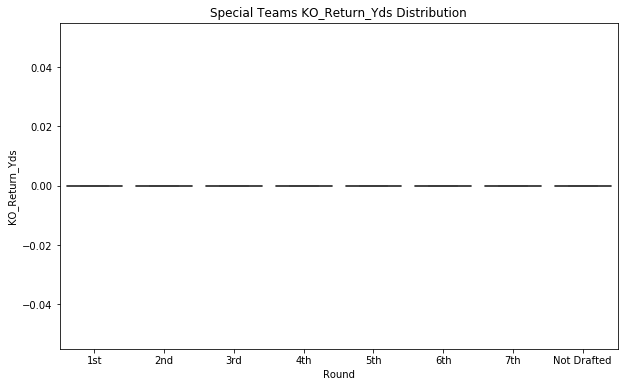

Special Teams Yds_per_KO_Return Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: Yds_per_KO_Return, dtype: float64
----------------------------------------
Special Teams Yds_per_KO_Return by Round
             Yds_per_KO_Return
Round                         
1st                       0.00
2nd                       0.00
3rd                       0.00
4th                       0.00
5th                       0.00
6th                       0.00
7th                       0.00
Not Drafted               0.00


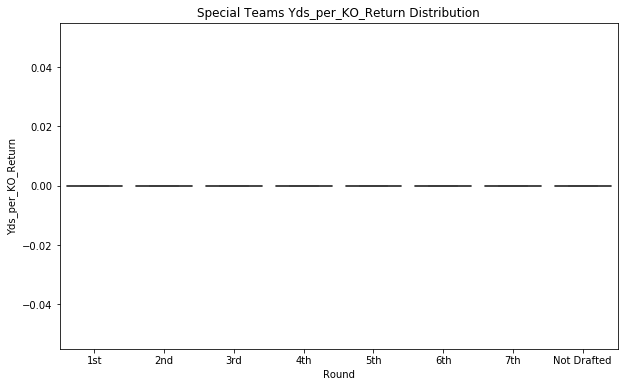

Special Teams KO_Returned_for_TD Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: KO_Returned_for_TD, dtype: float64
----------------------------------------
Special Teams KO_Returned_for_TD by Round
             KO_Returned_for_TD
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


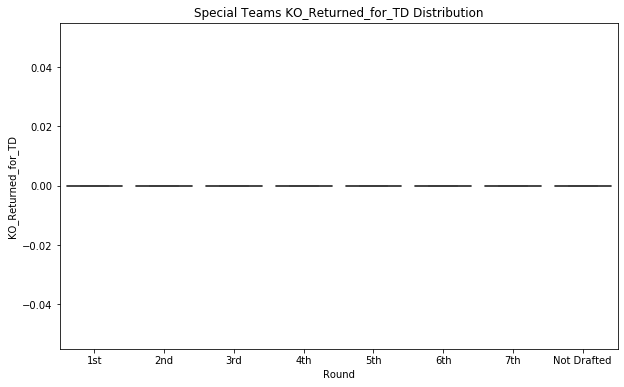

Special Teams Kickoff_ReturnsperGame Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: Kickoff_ReturnsperGame, dtype: float64
----------------------------------------
Special Teams Kickoff_ReturnsperGame by Round
             Kickoff_ReturnsperGame
Round                              
1st                            0.00
2nd                            0.00
3rd                            0.00
4th                            0.00
5th                            0.00
6th                            0.00
7th                            0.00
Not Drafted                    0.00


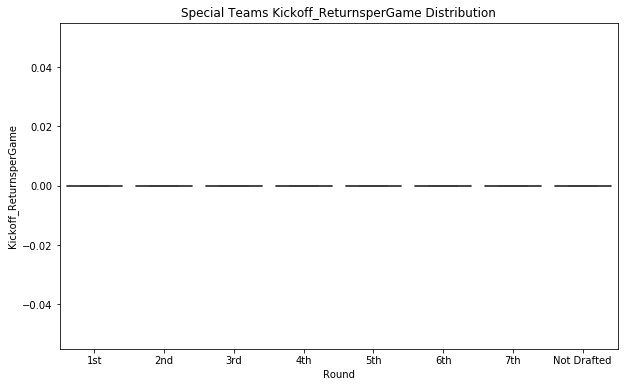

Special Teams KO_Return_YdsperGame Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: KO_Return_YdsperGame, dtype: float64
----------------------------------------
Special Teams KO_Return_YdsperGame by Round
             KO_Return_YdsperGame
Round                            
1st                          0.00
2nd                          0.00
3rd                          0.00
4th                          0.00
5th                          0.00
6th                          0.00
7th                          0.00
Not Drafted                  0.00


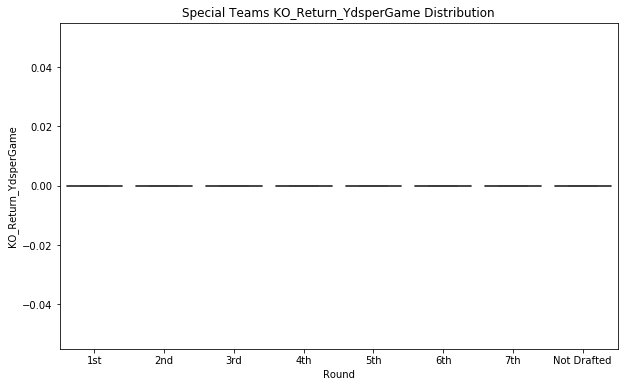

Special Teams KO_Returned_for_TDperGame Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: KO_Returned_for_TDperGame, dtype: float64
----------------------------------------
Special Teams KO_Returned_for_TDperGame by Round
             KO_Returned_for_TDperGame
Round                                 
1st                               0.00
2nd                               0.00
3rd                               0.00
4th                               0.00
5th                               0.00
6th                               0.00
7th                               0.00
Not Drafted                       0.00


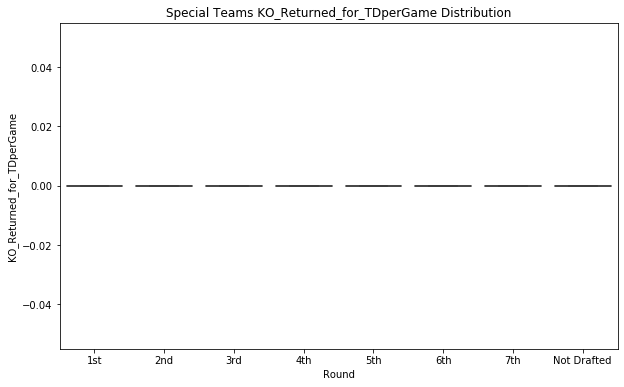

In [37]:
plot_stats('Special Teams', df, puntret_stats)

In [38]:
for i in puntret_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Special Teams', df,  i)
    print('')
    print('*' * 40)

PuntRet_Games ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   47.95     6.85 1.81    0.08
Residual 996.00 3760.94     3.78  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd  -0.3507 0.8985 -1.1666  0.4653  False
   1st         3rd  -0.3554 0.8529 -1.1367  0.4259  False
   1st         4th  -0.3994 0.7875 -1.2127  0.4139  False
   1st         5th  -0.6476 0.2446 -1.4689  0.1737  False
   1st         6th  -0.6561 0.2375  -1.483  0.1708  False
   1st         7th  -0.2781    0.9 -1.1079  0.5517  False
   1st Not Drafted  -0.6313 0.0418 -1.2502 -0.0124   True
   2nd         3rd  -0.0048    0.9 -0.8526  0.8431  False
   2nd         4th  -0.0487    0.9 -0.9261  0.8287  False
   2nd         5th   -0.297    0.9 -1.1818  0.5879  False
   2nd         6th  -0.3054    0.9 -1.19

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.0 0.5566   0.0   0.0  False
   1st         6th      0.0 0.5566   0.0   0.0  False
   1st         7th      0.0 0.5566   0.0   0.0  False
   1st Not Drafted      0.0 0.5566   0.0   0.0  False
   2nd         3rd      0.0 0.5566   0.0   0.0  False
   2nd         4th      0.0 0.5566   0.0   0.0  False
   

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.0 0.5566   0.0   0.0  False
   1st         6th      0.0 0.5566   0.0   0.0  False
   1st         7th      0.0 0.5566   0.0   0.0  False
   1st Not Drafted      0.0 0.5566   0.0   0.0  False
   2nd         3rd      0.0 0.5566   0.0   0.0  False
   2nd 

### College Stats - Scoring

In [39]:
scoring_stats = ['Scoring_Games', 'TD_Other', 'Ttl_TDs', 'TwoPT_Conversion', 'Safety', 'TTL_Points', 'TD_OtherperGame',
                 'Ttl_TDsperGame', 'TwoPT_ConversionperGame', 'SafetyperGame', 'TTL_PointsperGame']

In [40]:
df[scoring_stats].describe()

,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,TD_OtherperGame,Ttl_TDsperGame,TwoPT_ConversionperGame,SafetyperGame,TTL_PointsperGame
count,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00
mean,3.72,0.00,0.12,0.00,0.00,9.37,0.00,inf,0.00,0.00,inf
std,5.70,0.00,0.36,0.03,0.07,28.13,0.00,nan,0.00,0.01,nan
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,15.00,0.00,3.00,1.00,1.00,156.00,0.00,inf,0.07,0.08,inf


Special Teams Scoring_Games Summary:
count   1004.00
mean       3.72
std        5.70
min        0.00
25%        0.00
50%        0.00
75%       11.00
max       15.00
Name: Scoring_Games, dtype: float64
----------------------------------------
Special Teams Scoring_Games by Round
             Scoring_Games
Round                     
1st                   3.64
2nd                   3.88
3rd                   3.08
4th                   3.11
5th                   4.44
6th                   2.97
7th                   4.82
Not Drafted           3.79


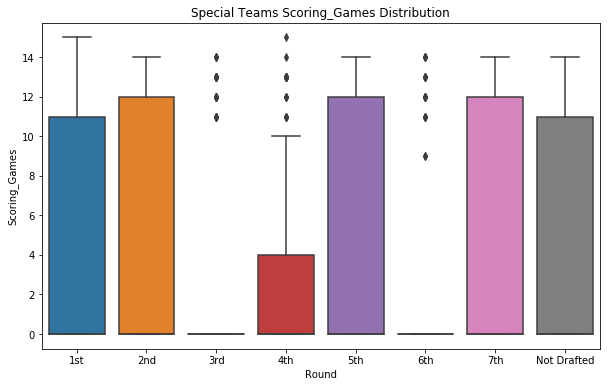

Special Teams TD_Other Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: TD_Other, dtype: float64
----------------------------------------
Special Teams TD_Other by Round
             TD_Other
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.00


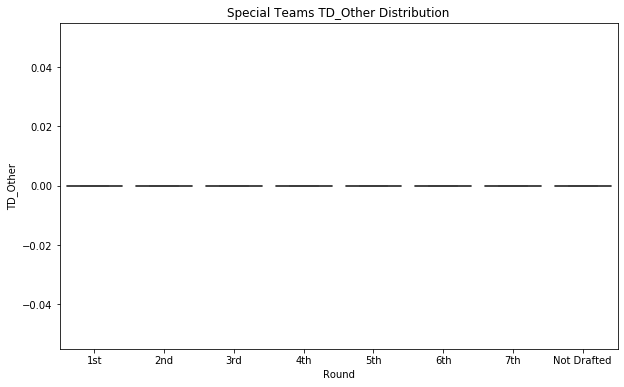

Special Teams Ttl_TDs Summary:
count   1004.00
mean       0.12
std        0.36
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        3.00
Name: Ttl_TDs, dtype: float64
----------------------------------------
Special Teams Ttl_TDs by Round
             Ttl_TDs
Round               
1st             0.24
2nd             0.21
3rd             0.14
4th             0.10
5th             0.16
6th             0.07
7th             0.11
Not Drafted     0.06


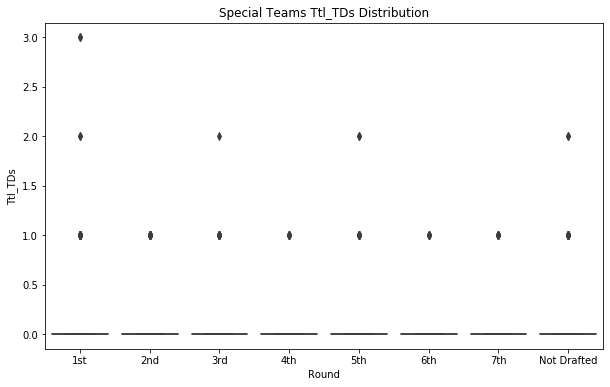

Special Teams TwoPT_Conversion Summary:
count   1004.00
mean       0.00
std        0.03
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: TwoPT_Conversion, dtype: float64
----------------------------------------
Special Teams TwoPT_Conversion by Round
             TwoPT_Conversion
Round                        
1st                      0.00
2nd                      0.00
3rd                      0.00
4th                      0.00
5th                      0.00
6th                      0.00
7th                      0.01
Not Drafted              0.00


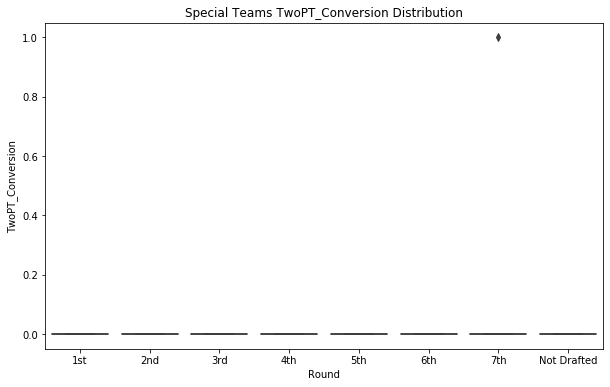

Special Teams Safety Summary:
count   1004.00
mean       0.00
std        0.07
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Safety, dtype: float64
----------------------------------------
Special Teams Safety by Round
             Safety
Round              
1st            0.00
2nd            0.00
3rd            0.01
4th            0.00
5th            0.01
6th            0.00
7th            0.02
Not Drafted    0.00


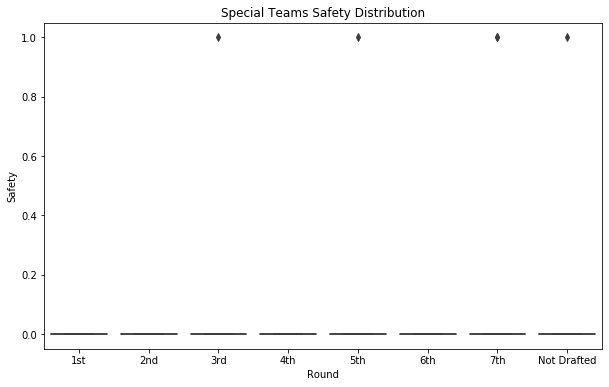

Special Teams TTL_Points Summary:
count   1004.00
mean       9.37
std       28.13
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      156.00
Name: TTL_Points, dtype: float64
----------------------------------------
Special Teams TTL_Points by Round
             TTL_Points
Round                  
1st                2.37
2nd                3.64
3rd                1.83
4th                3.86
5th               13.93
6th                9.42
7th                6.87
Not Drafted       16.84


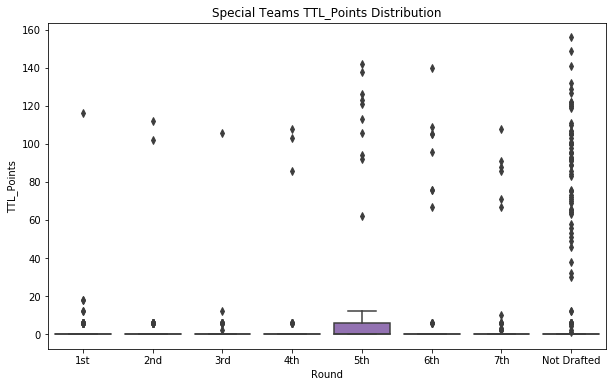

Special Teams TD_OtherperGame Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: TD_OtherperGame, dtype: float64
----------------------------------------
Special Teams TD_OtherperGame by Round
             TD_OtherperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


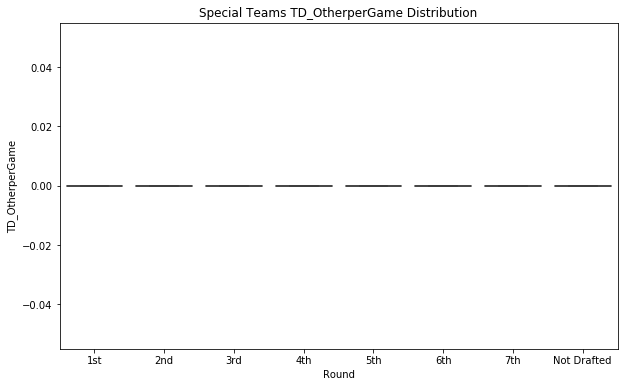

Special Teams Ttl_TDsperGame Summary:
count   1004.00
mean        inf
std         nan
min        0.00
25%        0.00
50%        0.00
75%        0.00
max         inf
Name: Ttl_TDsperGame, dtype: float64
----------------------------------------
Special Teams Ttl_TDsperGame by Round
             Ttl_TDsperGame
Round                      
1st                    0.02
2nd                    0.02
3rd                    0.01
4th                    0.01
5th                     inf
6th                    0.01
7th                    0.01
Not Drafted            0.00


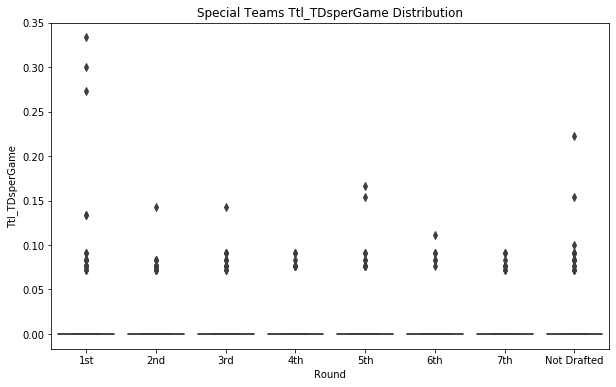

Special Teams TwoPT_ConversionperGame Summary:
count   1004.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.07
Name: TwoPT_ConversionperGame, dtype: float64
----------------------------------------
Special Teams TwoPT_ConversionperGame by Round
             TwoPT_ConversionperGame
Round                               
1st                             0.00
2nd                             0.00
3rd                             0.00
4th                             0.00
5th                             0.00
6th                             0.00
7th                             0.00
Not Drafted                     0.00


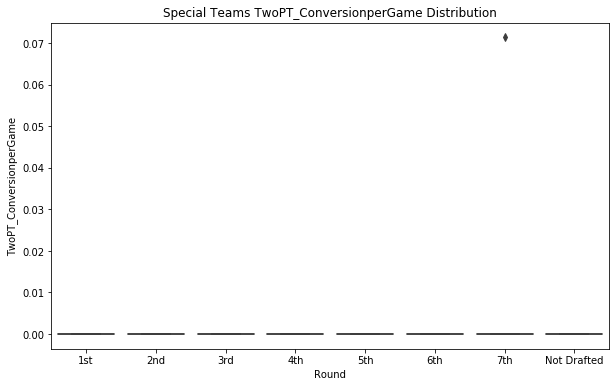

Special Teams SafetyperGame Summary:
count   1004.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.08
Name: SafetyperGame, dtype: float64
----------------------------------------
Special Teams SafetyperGame by Round
             SafetyperGame
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


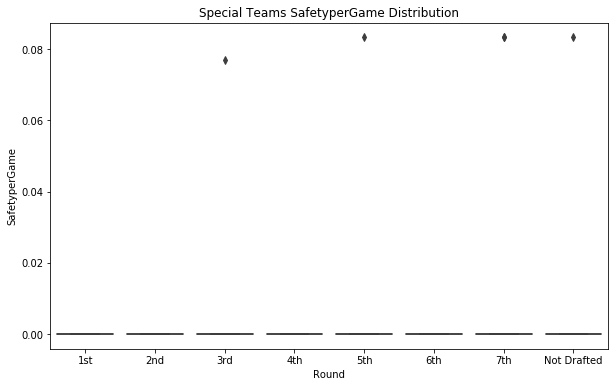

Special Teams TTL_PointsperGame Summary:
count   1004.00
mean        inf
std         nan
min        0.00
25%        0.00
50%        0.00
75%        0.00
max         inf
Name: TTL_PointsperGame, dtype: float64
----------------------------------------
Special Teams TTL_PointsperGame by Round
             TTL_PointsperGame
Round                         
1st                       0.21
2nd                       0.29
3rd                       0.14
4th                       0.32
5th                        inf
6th                       0.73
7th                       0.56
Not Drafted               1.37


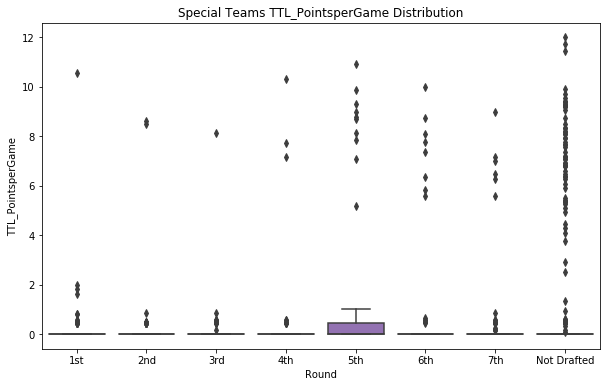

In [41]:
plot_stats('Special Teams', df, scoring_stats)

In [42]:
for i in scoring_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Special Teams', df, i)
    print('')
    print('*' * 40)

Scoring_Games ANOVA Test:
----------------------------------------
             df   sum_sq  mean_sq    F  PR(>F)
Round      7.00   280.48    40.07 1.24    0.28
Residual 996.00 32263.62    32.39  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.2378    0.9  -2.152 2.6276  False
   1st         3rd  -0.5638    0.9 -2.8522 1.7246  False
   1st         4th  -0.5301    0.9 -2.9123 1.8521  False
   1st         5th   0.8032    0.9 -1.6024 3.2087  False
   1st         6th  -0.6749    0.9 -3.0968  1.747  False
   1st         7th   1.1835 0.7948 -1.2468 3.6139  False
   1st Not Drafted   0.1474    0.9 -1.6652   1.96  False
   2nd         3rd  -0.8016    0.9 -3.2848 1.6817  False
   2nd         4th  -0.7679    0.9 -3.3378  1.802  False
   2nd         5th   0.5654    0.9 -2.0262  3.157  False
   2nd         6th  -0.9127    0.9 -3.5194 1.6941 

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------
   1st         2nd   1.2764    0.9 -10.2816 12.8345  False
   1st         3rd  -0.5394    0.9 -11.6071 10.5283  False
   1st         4th   1.4891    0.9 -10.0319 13.0102  False
   1st         5th  11.5638 0.0528  -0.0704  23.198  False
   1st         6th   7.0506 0.5866  -4.6627 18.7639  False
   1st         7th   4.5026    0.9  -7.2515 16.2566  False
   1st Not Drafted  14.4673  0.001   5.7009 23.2337   True
   2nd         3rd  -1.8159    0.9 -13.8259 10.1941  False
   2nd         4th   0.2127    0.9 -12.2164 12.6418  False
   2nd         5th  10.2874 0.1994  -2.2466 22.8214  False
   2nd         6th   5.7742 0.8474  -6.8333 18.3816  False
   2nd         7th   3.2261    0.9  -9.4192 15.8715  False
   2nd Not Drafted  13.1909 0.0015   3.2613 23.1205   True
   3rd         4th   2.0286    0.9  -9.9459  14.003  Fal

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd      0.0    0.9 -0.0024 0.0024  False
   1st         3rd   0.0007    0.9 -0.0016 0.0031  False
   1st         4th      0.0    0.9 -0.0024 0.0024  False
   1st         5th   0.0009    0.9 -0.0015 0.0034  False
   1st         6th      0.0    0.9 -0.0025 0.0025  False
   1st         7th    0.002  0.235 -0.0005 0.0044  False
   1st Not Drafted   0.0002    0.9 -0.0016 0.0021  False
   2nd         3rd   0.0007    0.9 -0.0018 0.0033  False
   2nd         4th      0.0    0.9 -0.0026 0.0026  False
   2nd         5th   0.0009    0.9 -0.0017 0.0036  False
   2nd         6th      0.0    0.9 -0.0026 0.0026  False
   2nd         7th    0.002 0.3255 -0.0007 0.0046  False
   2nd Not Drafted   0.0002    0.9 -0.0018 0.0023  False
   3rd         4th  -0.0007    0.9 -0.0032 0.0018  False
   3rd         5th   0.0002    